In [1]:
import pandas as pd

In [2]:
df_ccus = pd.read_excel("C:/Users/rjsou/Downloads/datasets/IEA CCUS Projects Database 2024 (1).xlsx", sheet_name=3)

In [3]:
df_ccus['Country'].unique()

array(['France', 'Qatar', 'United States', 'Indonesia', 'United Kingdom',
       'Australia', 'United Arab Emirates', 'Netherlands',
       "People's Republic of China", 'Canada', 'Finland', 'Germany',
       'Unknown', 'Sweden', 'Norway', 'Bahrain', 'Denmark', 'Bulgaria',
       'Belgium', 'Thailand', 'Italy-Greece', 'Hungary', 'Malaysia',
       'South Korea', 'Latvia', 'Italy', 'France-Italy', 'Austria',
       'Latvia-Lithuania', 'Singapore', 'Iceland', 'Croatia', 'Russia',
       'India', 'Netherlands-Germany', 'Mexico', 'Japan',
       'Poland, Latvia, Lithuania', 'Spain', 'Japan-Australia', 'Greece',
       'Ireland', 'Belgium-Norway', 'Brazil', 'Romania', 'Poland',
       'Kenya', 'Chile', 'Uruguay', 'Algeria', 'Japan-Malaysia',
       'Saudi Arabia', 'Swizterland', 'Portugal', 'Oman',
       'Australia-Japan', 'Japan-Indonesia', 'Belgium-Germany',
       'Japan-unknown', 'Lithuania', 'Papua New Guinea', 'New Zealand',
       'Lybia', 'Taiwan',
       'Belgium, Germany, Netherl

In [4]:
df_ccus_clean = df_ccus[df_ccus.columns.drop(list(df_ccus.filter(regex='Link')))]
df_ccus_clean = df_ccus_clean[df_ccus_clean.columns.drop(list(df_ccus_clean.filter(regex='Ref')))]

df_ccus_clean = df_ccus_clean.rename(
    columns={
        'Estimated capacity by IEA (Mt CO2/yr)': 'Estimated capacity'
    })

df_ccus_clean = df_ccus_clean.drop(
    columns=[
        'ID',
        'Project name',
        'Partners',
        'FID',
        'Part of CCUS hub',
        'Announced capacity (Mt CO2/yr)',
        'Announcement',
        'Region',
        'Project phase'
    ])

In [5]:
df_ccus['Country'] = df_ccus['Country'].str.split('-')
df_ccus = df_ccus.explode('Country').dropna(subset='Country')

In [6]:
# Filter rows where Operation is NaN or in the future (after 2024)
df_ccus_clean = df_ccus_clean[pd.to_numeric(df_ccus_clean['Operation'], errors='coerce').notna()]
df_ccus_clean = df_ccus_clean[df_ccus_clean['Operation'].apply(lambda x: x <= 2024)]

# Define the function to get operational years
def get_operational_years(row):
    # Ensure we have a valid operation year
    if pd.notna(row['Operation']):
        operation_year = int(row['Operation'])
        # If suspension is NaN or if the suspension year is in the future, the project is ongoing
        if pd.isna(row['Suspension/decommissioning']) or int(row['Suspension/decommissioning']) > 2024:
            return list(range(operation_year, 2024 + 1))  # Ongoing, so up to 2024
        else:
            suspension_year = int(row['Suspension/decommissioning'])
            return list(range(operation_year, suspension_year + 1))  # If suspension year is provided
    return []

# Apply the function to get operational years
df_ccus_clean['Operational Years'] = df_ccus_clean.apply(get_operational_years, axis=1)

# Inspect the operational years
display(df_ccus_clean[['Country', 'Sector', 'Operational Years', 'Project type']])

,Country,Sector,Operational Years,Project type
20,United States,Storage,[2024],Storage
21,United States,Biofuels,[2024],Capture
22,United States,Biofuels,[2024],Capture
28,Canada,DAC,[2024],CCU
40,Canada,Transport,[2024],Transport
...,...,...,...,...
798,United States,Other fuel transformation,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...",Full chain
818,United States,Hydrogen or ammonia,[2024],Full chain
822,Latvia,Hydrogen or ammonia,[2024],CCU
826,Canada,Storage,"[2020, 2021, 2022, 2023, 2024]",Storage


In [7]:
# Create capacity features for each Fate of Carbon using only the Estimated Capacity
df_ccus_clean['dedicated_storage_capacity'] = df_ccus_clean.apply(
    lambda row: row['Estimated capacity'] if row['Fate of carbon'] == 'Dedicated storage' else 0, axis=1)

# Classify EOR and Use separately
df_ccus_clean['eor_capacity'] = df_ccus_clean.apply(
    lambda row: row['Estimated capacity'] if row['Fate of carbon'] == 'EOR' else 0, axis=1)

df_ccus_clean['use_capacity'] = df_ccus_clean.apply(
    lambda row: row['Estimated capacity'] if row['Fate of carbon'] == 'Use' else 0, axis=1)

# Unknown or unspecified fate
df_ccus_clean['unknown_capacity'] = df_ccus_clean.apply(
    lambda row: row['Estimated capacity'] if row['Fate of carbon'] == 'Unknown/unspecified' else 0, axis=1)

# You can aggregate these and then merge them with the supply/demand dataset
# Create an aggregated column for all mixed strategies, if you wish:
df_ccus_clean['mixed_co2_capacity'] = df_ccus_clean.apply(
    lambda row: row['Estimated capacity'] if row['Fate of carbon'] in ['EOR', 'Use'] else 0, axis=1)

# Inspect the new columns
print(df_ccus_clean[['Country', 'Sector', 'dedicated_storage_capacity', 'eor_capacity', 'use_capacity', 'unknown_capacity', 'mixed_co2_capacity']].head())


          Country     Sector  dedicated_storage_capacity  eor_capacity  \
20  United States    Storage                         1.4           0.0   
21  United States   Biofuels                         0.2           0.0   
22  United States   Biofuels                         0.2           0.0   
28         Canada        DAC                         0.0           0.0   
40         Canada  Transport                         7.0           0.0   

    use_capacity  unknown_capacity  mixed_co2_capacity  
20         0.000               0.0               0.000  
21         0.000               0.0               0.000  
22         0.000               0.0               0.000  
28         0.001               0.0               0.001  
40         0.000               0.0               0.000  


In [8]:
# First, create a list of years where the project was operational (between operation and suspension years)
def get_operational_years(row):
    if pd.notna(row['Operation']) and pd.isna(row['Suspension/decommissioning']):
        return list(range(int(row['Operation']), 2025))  # Assuming the latest year for analysis is 2023
    elif pd.notna(row['Operation']) and pd.notna(row['Suspension/decommissioning']):
        return list(range(int(row['Operation']), int(row['Suspension/decommissioning']) + 1))
    return []

# Apply the function to get operational years
df_ccus_clean['Year'] = df_ccus_clean.apply(get_operational_years, axis=1)


df_ccus_clean = df_ccus_clean.drop(
    columns=[
        'Suspension/decommissioning',
        'Operation'
    ])

# Inspect the operational years
display(df_ccus_clean)


,Country,Project type,Project Status,Estimated capacity,Sector,Fate of carbon,Operational Years,dedicated_storage_capacity,eor_capacity,use_capacity,unknown_capacity,mixed_co2_capacity,Year
20,United States,Storage,Planned,1.400,Storage,Dedicated storage,[2024],1.40,0.0,0.000,0.0,0.000,[2024]
21,United States,Capture,Planned,0.200,Biofuels,Dedicated storage,[2024],0.20,0.0,0.000,0.0,0.000,[2024]
22,United States,Capture,Planned,0.200,Biofuels,Dedicated storage,[2024],0.20,0.0,0.000,0.0,0.000,[2024]
28,Canada,CCU,Planned,0.001,DAC,Use,[2024],0.00,0.0,0.001,0.0,0.001,[2024]
40,Canada,Transport,Under construction,7.000,Transport,Dedicated storage,[2024],7.00,0.0,0.000,0.0,0.000,[2024]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,United States,Full chain,Operational,0.900,Other fuel transformation,EOR,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...",0.00,0.9,0.000,0.0,0.900,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202..."
818,United States,Full chain,Planned,1.650,Hydrogen or ammonia,Dedicated storage,[2024],1.65,0.0,0.000,0.0,0.000,[2024]
822,Latvia,CCU,Planned,NaN,Hydrogen or ammonia,Use,[2024],0.00,0.0,NaN,0.0,NaN,[2024]
826,Canada,Storage,Operational,3.000,Storage,EOR,"[2020, 2021, 2022, 2023, 2024]",0.00,3.0,0.000,0.0,3.000,"[2020, 2021, 2022, 2023, 2024]"


In [9]:
# Step 1: Exploding the 'Operational Years' list into individual rows
df_ccus_clean_exploded = df_ccus_clean.explode('Year').reset_index(drop=True)
# Step 1: Rename the 'Sector' column to 'Subsector'
df_ccus_clean_exploded = df_ccus_clean_exploded.rename(columns={'Sector': 'Subsector'})

In [10]:
# Step 1: Sum all the capacity columns to create a new 'total_capacity' column
df_ccus_clean_exploded['total_capacity'] = df_ccus_clean_exploded[['dedicated_storage_capacity', 'eor_capacity', 'use_capacity', 
                                                 'unknown_capacity', 'mixed_co2_capacity']].sum(axis=1)

# Step 2: Display the updated dataset to verify the new 'total_capacity' column
display(df_ccus_clean_exploded[['Country', 'Year', 'Subsector', 'total_capacity', 'Project type']].head())


,Country,Year,Subsector,total_capacity,Project type
0,United States,2024,Storage,1.400,Storage
1,United States,2024,Biofuels,0.200,Capture
2,United States,2024,Biofuels,0.200,Capture
3,Canada,2024,DAC,0.002,CCU
4,Canada,2024,Transport,7.000,Transport


In [11]:
df_ccus_final = df_ccus_clean_exploded.drop(columns=['Project Status', 'Estimated capacity', 'Operational Years', 'Fate of carbon'])

In [12]:
df_ccus_final = df_ccus_final.rename(columns={'Subsector': 'CCUS_sector'})

In [13]:
df_ccus_final['Country'].unique()

array(['United States', 'Canada', 'Belgium', 'Australia',
       "People's Republic of China", 'Iceland', 'United Arab Emirates',
       'United Kingdom', 'Germany', 'Algeria', 'Norway', 'Japan', 'Oman',
       'Hungary', 'Netherlands', 'Brazil', 'New Zealand', 'Qatar',
       'Saudi Arabia', 'Latvia'], dtype=object)

## Remove transport, storage and T&S and use as control variables

In [14]:
# 1. Separate treatment projects from infrastructure projects
# Exclude DAC from 'Capture' and treat it as a control
treatment_projects = df_ccus_final[
    (df_ccus_final['Project type'].isin(['Full chain', 'CCU'])) | 
    ((df_ccus_final['Project type'] == 'Capture') & (df_ccus_final['CCUS_sector'] != 'DAC'))
].copy()

# Separate DAC projects as controls
dac_projects = df_ccus_final[
    (df_ccus_final['Project type'] == 'Capture') & (df_ccus_final['CCUS_sector'] == 'DAC')
].copy()

# Separate infrastructure projects
infrastructure_projects = df_ccus_final[
    df_ccus_final['Project type'].isin(['Transport', 'Storage', 'T&S'])
].copy()


In [15]:
# Step 2: Aggregate infrastructure capacity by country, year, and project type
# For transport projects
transport_controls = infrastructure_projects[infrastructure_projects['Project type'] == 'Transport'].groupby(
    ['Country', 'Year', 'Project type']
).agg({
    'total_capacity': 'sum',
    'dedicated_storage_capacity': 'sum', 
    'eor_capacity': 'sum',
    'use_capacity': 'sum',
    'unknown_capacity': 'sum',
    'mixed_co2_capacity': 'sum'
}).reset_index().rename(columns={
    'total_capacity': 'transport_capacity',
    'dedicated_storage_capacity': 'transport_dedicated_storage', 
    'eor_capacity': 'transport_eor',
    'use_capacity': 'transport_use',
    'unknown_capacity': 'transport_unknown',
    'mixed_co2_capacity': 'transport_mixed'
})

# For storage projects
storage_controls = infrastructure_projects[infrastructure_projects['Project type'] == 'Storage'].groupby(
    ['Country', 'Year', 'Project type']
).agg({
    'total_capacity': 'sum',
    'dedicated_storage_capacity': 'sum', 
    'eor_capacity': 'sum',
    'use_capacity': 'sum',
    'unknown_capacity': 'sum',
    'mixed_co2_capacity': 'sum'
}).reset_index().rename(columns={
    'total_capacity': 'storage_capacity',
    'dedicated_storage_capacity': 'storage_dedicated_storage', 
    'eor_capacity': 'storage_eor',
    'use_capacity': 'storage_use',
    'unknown_capacity': 'storage_unknown',
    'mixed_co2_capacity': 'storage_mixed'
})

# For T&S projects
ts_controls = infrastructure_projects[infrastructure_projects['Project type'] == 'T&S'].groupby(
    ['Country', 'Year', 'Project type']
).agg({
    'total_capacity': 'sum',
    'dedicated_storage_capacity': 'sum', 
    'eor_capacity': 'sum',
    'use_capacity': 'sum',
    'unknown_capacity': 'sum',
    'mixed_co2_capacity': 'sum'
}).reset_index().rename(columns={
    'total_capacity': 'ts_capacity',
    'dedicated_storage_capacity': 'ts_dedicated_storage', 
    'eor_capacity': 'ts_eor',
    'use_capacity': 'ts_use',
    'unknown_capacity': 'ts_unknown',
    'mixed_co2_capacity': 'ts_mixed'
})

# Aggregate DAC capacity by country, year, and project type
dac_controls = dac_projects.groupby(['Country', 'Year', 'Project type']).agg({
    'total_capacity': 'sum'
}).reset_index().rename(columns={
    'total_capacity': 'dac_capacity'
})

In [16]:
# Step 3: Add infrastructure and DAC controls to treatment dataset
# First merge transport controls
df_with_controls = pd.merge(treatment_projects, transport_controls, on=['Country', 'Year', 'Project type'], how='left')

# Then merge storage controls
df_with_controls = pd.merge(df_with_controls, storage_controls, on=['Country', 'Year', 'Project type'], how='left')

# Then merge T&S controls
df_with_controls = pd.merge(df_with_controls, ts_controls, on=['Country', 'Year', 'Project type'], how='left')

# Finally merge DAC controls
df_with_controls = pd.merge(df_with_controls, dac_controls, on=['Country', 'Year', 'Project type'], how='left')

# Fill NaN values in control columns with 0
control_columns = [col for col in df_with_controls.columns if any(x in col for x in ['transport_', 'storage_', 'ts_', 'dac_'])]
df_with_controls = df_with_controls.fillna(0)

C:\Users\rjsou\AppData\Local\Temp\ipykernel_42132\3646155536.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_with_controls = df_with_controls.fillna(0)


In [82]:
df_ccus_final = df_with_controls.copy()

In [83]:
a = df_ccus_final

len(a['Country'].unique()), a['Year'].min(), a['Year'].max(), len(a)

(20, np.int64(1972), np.int64(2026), 589)

In [84]:
len(df_ccus_final['CCUS_sector'].unique())

9

# Supply/demand dataset

In [17]:
df_supply_demand = pd.read_excel("C:/Users/rjsou/Downloads/datasets/WorldEnergyBalancesHighlights2024.xlsx", sheet_name=3, header=1)

In [18]:
"""for a in df_supply_demand['Flow'].unique():
    print(f'- `{a}`')"""

"for a in df_supply_demand['Flow'].unique():\n    print(f'- `{a}`')"

In [19]:
demand_flows = [
    'Industry (PJ)',
    'Transport (PJ)',
    'Residential (PJ)',
    'Commercial and public services (PJ)',
    'Other final consumption (PJ)',
    'Total energy supply (PJ)'
]

supply_flows = [
    'Electricity output (GWh)'
]

all_flows = demand_flows + supply_flows

In [20]:
df_supply_demand_clean = df_supply_demand.drop(
    columns=['NoCountry', 'NoProduct', 'NoFlow', '2023 Provisional'],
    errors='ignore'
)

remove_countries = [
    'World',
    'IEA Total',
    'IEA and Accession/Association countries',
    'OECD Total',
    'Non-OECD Total'
]

keep_countries = [c for c in df_supply_demand['Country'].unique() if c not in remove_countries]
df_supply_demand_clean = df_supply_demand_clean[df_supply_demand_clean['Country'].isin(keep_countries)]
df_supply_demand_clean = df_supply_demand_clean[df_supply_demand_clean['Flow'].isin(all_flows)]

print(df_supply_demand_clean['Country'].unique())

# No NaNs
display(df_supply_demand_clean)

['Australia' 'Austria' 'Belgium' 'Canada' 'Chile' 'Colombia' 'Costa Rica'
 'Czech Republic' 'Denmark' 'Estonia' 'Finland' 'France' 'Germany'
 'Greece' 'Hungary' 'Iceland' 'Ireland' 'Israel' 'Italy' 'Japan' 'Korea'
 'Latvia' 'Lithuania' 'Luxembourg' 'Mexico' 'Netherlands' 'New Zealand'
 'Norway' 'Poland' 'Portugal' 'Slovak Republic' 'Slovenia' 'Spain'
 'Sweden' 'Switzerland' 'Republic of Turkiye' 'United Kingdom'
 'United States' 'Argentina' 'Brazil' "People's Republic of China" 'Egypt'
 'India' 'Indonesia' 'Kenya' 'Morocco' 'Senegal' 'Singapore'
 'South Africa' 'Thailand' 'Ukraine' 'Africa' 'Non-OECD Americas'
 'Non-OECD Asia (including China)' 'Non-OECD Europe and Eurasia'
 'Middle East']


,Country,Product,Flow,1971,1972,1973,1974,1975,1976,1977,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
3,Australia,"Coal, peat and oil shale",Total energy supply (PJ),884.29747,923.250159,945.54188,928.32307,998.126664,996.366969,1081.563936,...,1831.201248,1736.5671,1797.035545,1863.051458,1996.773936,1930.457749,1956.712871,1782.618877,1683.993595,1567.046515
7,Australia,"Coal, peat and oil shale",Industry (PJ),204.457789,195.678786,204.95658,182.453354,191.06417,183.933484,181.063864,...,98.315664,102.191297,97.76549,112.944498,111.848365,121.198084,119.304796,111.072902,113.123895,112.926093
8,Australia,"Coal, peat and oil shale",Transport (PJ),3.432,1.456002,0.866282,0.313512,0.336363,0.282776,0.25707,...,0,0,0.025699,0,0,0,0,0,0,0
9,Australia,"Coal, peat and oil shale",Residential (PJ),9.914581,9.851025,7.838452,14.835582,13.865342,12.173301,10.604281,...,0.051301,0,0.020997,0.020997,0.020997,0.020997,0.020997,0,0.020997,0
10,Australia,"Coal, peat and oil shale",Commercial and public services (PJ),2.599999,3.9,3.937652,10.945811,10.706518,10.425831,10.203433,...,0.148698,0.2782,0.2895,0.324096,0.5129,0.5094,0.578,0.794496,0.213698,0.144198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6815,Non-OECD Europe and Eurasia,Total,Electricity output (GWh),892621,958927,1021343,1090105,1161327,1244766,1292451,...,1738667.145,1730151.901,1719050.709,1749412.4,1750023.581,1803549.186,1791483.034,1755598.668,1871145.38,1816468.988
6816,Middle East,Fossil fuels,Electricity output (GWh),15961,18447,24007,27019,31106,36663,42379,...,922681,999700,1049931,1080098,1135234.136,1158472.417,1178728.836,1201574.35,1250794.321,1275313.191
6817,Middle East,Nuclear,Electricity output (GWh),0,0,0,0,0,0,0,...,4546,4472,2914,6620,7513.664,7450.452,6756.743,7317.619,14425.495,28680.739
6818,Middle East,Renewable sources,Electricity output (GWh),3769,4597,3627,4971,5456,6464,7347,...,24191,20256,18520,22895,21747.783,23708.374,46865.522,40587.681,31899.264,37584.16


In [21]:
# Reshape the data to long form
df_supply_demand_long = df_supply_demand_clean.melt(
    id_vars=['Country', 'Product', 'Flow'],
    var_name='Year',
    value_name='Energy (PJ)'
)

# Convert 'Year' to numeric
df_supply_demand_long['Year'] = pd.to_numeric(df_supply_demand_long['Year'], errors='coerce')
df_supply_demand_long['Energy (PJ)'] = pd.to_numeric(df_supply_demand_long['Energy (PJ)'], errors='coerce')

# Dropping records that are either not available '..' or confidential 'c'
df_supply_demand_long['Flow'].unique()

array(['Total energy supply (PJ)', 'Industry (PJ)', 'Transport (PJ)',
       'Residential (PJ)', 'Commercial and public services (PJ)',
       'Other final consumption (PJ)', 'Electricity output (GWh)'],
      dtype=object)

In [22]:
df_supply = df_supply_demand_long[df_supply_demand_long['Flow'].isin(supply_flows)]
df_demand = df_supply_demand_long[df_supply_demand_long['Flow'].isin(demand_flows)]

# Step 4: Pivot the demand data to get separate columns for each energy product and sector
demand_final = df_demand.pivot_table(
    index=['Year', 'Country', 'Flow'], 
    columns='Product', 
    values='Energy (PJ)', 
    aggfunc='sum').reset_index()

supply_final = df_supply.pivot_table(
    index=['Year', 'Country'], 
    columns='Product', 
    values='Energy (PJ)', 
    aggfunc='sum').reset_index()

# Add prefixes to the value columns
demand_cols = list(demand_final.columns[:3])
demand_cols.extend('demand_' + demand_final.columns.values[3:])
demand_final.columns = demand_cols

supply_cols = list(supply_final.columns[:3])
supply_cols.extend('supply_' + supply_final.columns.values[3:])
supply_final.columns = supply_cols

print(f'Supply NaNs: {len(supply_final) != len(supply_final.dropna())}')
print(f'Demand NaNs: {len(demand_final) != len(demand_final.dropna())}')
display(supply_final)
display(demand_final)

Supply NaNs: False
Demand NaNs: False


,Year,Country,Fossil fuels,supply_Nuclear,supply_Renewable sources,supply_Total
0,1971,Africa,68055.000,0.000,23695.000,91750.000
1,1971,Argentina,0.000,0.000,0.000,0.000
2,1971,Australia,41201.000,0.000,11844.000,53045.000
3,1971,Austria,11752.000,0.000,16450.000,28202.000
4,1971,Belgium,33103.000,0.000,134.000,33237.000
...,...,...,...,...,...,...
2907,2022,Switzerland,416.264,24153.085,35986.489,61730.521
2908,2022,Thailand,151884.393,0.000,34091.609,185976.002
2909,2022,Ukraine,33685.165,62068.608,16049.711,111862.964
2910,2022,United Kingdom,133954.575,47723.061,135159.038,322092.740


,Year,Country,Flow,"demand_Coal, peat and oil shale","demand_Crude, NGL and feedstocks",demand_Electricity,demand_Heat,demand_Natural gas,demand_Nuclear,demand_Oil products,demand_Renewables and waste,demand_Total
0,1971,Africa,Commercial and public services (PJ),34.696748,0.000000,17.290793,0.000000,0.447301,0.000000,16.748975,82.436015,151.619833
1,1971,Africa,Industry (PJ),443.294285,0.000000,186.019206,0.000000,22.924798,0.000000,318.631829,240.928033,1211.798160
2,1971,Africa,Other final consumption (PJ),38.788755,0.000000,21.322786,0.000000,0.000000,0.000000,211.640328,34.513999,306.265864
3,1971,Africa,Residential (PJ),104.793561,0.000000,53.463594,0.000000,2.044800,0.000000,114.934824,3011.453097,3286.689874
4,1971,Africa,Total energy supply (PJ),1505.958863,1557.179597,13.017603,0.000000,97.659903,0.000000,-108.121204,4155.797801,7221.492554
...,...,...,...,...,...,...,...,...,...,...,...,...
17467,2022,United States,Industry (PJ),539.486673,0.000000,3040.890169,180.867503,5814.677232,0.000000,905.455191,1281.072584,11762.449350
17468,2022,United States,Other final consumption (PJ),0.000000,0.000000,1042.820637,0.000000,734.999661,0.000000,6000.774182,79.074421,7857.668901
17469,2022,United States,Residential (PJ),0.000000,0.000000,5430.907386,0.000000,4883.622614,0.000000,621.674076,618.121153,11554.325230
17470,2022,United States,Total energy supply (PJ),10016.167870,39834.291330,148.363131,0.000000,32292.088690,8767.293458,-8112.634491,8033.112325,90978.682310


In [23]:
supply_demand_final = pd.merge(demand_final, supply_final, on=['Year', 'Country'], how='left')

print(f'Size Of dataframes, original df_supply_demand: {len(df_supply_demand)} (long form with years)')
print(f'    df_demand ({len(df_demand)}) -> demand_final ({len(demand_final)} previously 18500)')
print(f'    df_supply ({len(df_supply)}) -> supply_final ({len(supply_final)})')
print(f'    df_supply_demand_long ({len(df_supply_demand_long)}) -> supply_dmenad_final ({len(supply_demand_final)}) previously 18500')

supply_demand_final

Size Of dataframes, original df_supply_demand: 6832 (long form with years)
    df_demand (157248) -> demand_final (17472 previously 18500)
    df_supply (11648) -> supply_final (2912)
    df_supply_demand_long (168896) -> supply_dmenad_final (17472) previously 18500


,Year,Country,Flow,"demand_Coal, peat and oil shale","demand_Crude, NGL and feedstocks",demand_Electricity,demand_Heat,demand_Natural gas,demand_Nuclear,demand_Oil products,demand_Renewables and waste,demand_Total,Fossil fuels,supply_Nuclear,supply_Renewable sources,supply_Total
0,1971,Africa,Commercial and public services (PJ),34.696748,0.000000,17.290793,0.000000,0.447301,0.000000,16.748975,82.436015,151.619833,68055.000,0.000,23695.000,91750.00
1,1971,Africa,Industry (PJ),443.294285,0.000000,186.019206,0.000000,22.924798,0.000000,318.631829,240.928033,1211.798160,68055.000,0.000,23695.000,91750.00
2,1971,Africa,Other final consumption (PJ),38.788755,0.000000,21.322786,0.000000,0.000000,0.000000,211.640328,34.513999,306.265864,68055.000,0.000,23695.000,91750.00
3,1971,Africa,Residential (PJ),104.793561,0.000000,53.463594,0.000000,2.044800,0.000000,114.934824,3011.453097,3286.689874,68055.000,0.000,23695.000,91750.00
4,1971,Africa,Total energy supply (PJ),1505.958863,1557.179597,13.017603,0.000000,97.659903,0.000000,-108.121204,4155.797801,7221.492554,68055.000,0.000,23695.000,91750.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17467,2022,United States,Industry (PJ),539.486673,0.000000,3040.890169,180.867503,5814.677232,0.000000,905.455191,1281.072584,11762.449350,2696235.457,803668.567,959231.982,4472902.01
17468,2022,United States,Other final consumption (PJ),0.000000,0.000000,1042.820637,0.000000,734.999661,0.000000,6000.774182,79.074421,7857.668901,2696235.457,803668.567,959231.982,4472902.01
17469,2022,United States,Residential (PJ),0.000000,0.000000,5430.907386,0.000000,4883.622614,0.000000,621.674076,618.121153,11554.325230,2696235.457,803668.567,959231.982,4472902.01
17470,2022,United States,Total energy supply (PJ),10016.167870,39834.291330,148.363131,0.000000,32292.088690,8767.293458,-8112.634491,8033.112325,90978.682310,2696235.457,803668.567,959231.982,4472902.01


In [24]:
supply_demand_final = supply_demand_final.rename(
    columns={
        'Flow': 'Sector',
        'Fossil fuels': 'Supply_fossil_fuels'
    }
)#.drop(columns=['supply_Total', 'demand_Total'])

In [25]:
cols = list(supply_demand_final.columns)
cols[2:] = [c.replace(' ', '_').capitalize().replace(',', '') for c in cols[2:]]
cols

supply_demand_final.columns = cols

In [94]:
a = supply_demand_final

len(a['Country'].unique()), a['Year'].min(), a['Year'].max(), len(a)

(56, np.int64(1971), np.int64(2022), 17472)

# Emissions

# Emissions x2

In [26]:
df_long = pd.read_excel("C:/Users/rjsou/Downloads/EDGAR_AR5_GHG_1970_2023.xlsx", sheet_name=1, header=9)

# Columns to keep as identifiers (non-year columns)
id_vars = [
    'IPCC_annex', 'C_group_IM24_sh', 'Country_code_A3', 'Name',
    'ipcc_code_2006_for_standard_report',
    'ipcc_code_2006_for_standard_report_name', 'Substance', 'fossil_bio'
]

# Melt the dataframe
df_long = df_long.melt(
    id_vars=id_vars,
    value_vars=[col for col in df_long.columns if col.startswith('Y_')],
    var_name='Year',
    value_name='Value'
)

# Clean Year column (remove "Y_" prefix) IN THE MELTED DF
df_long['Year'] = df_long['Year'].str.replace('Y_', '').astype(int)  # Use df_long here

df_long = df_long.rename(
    columns={
        'Name': 'Country',
        'ipcc_code_2006_for_standard_report_name': 'Sector',
        'Value': 'Emissions'
    }
)

# Sort by Country, Sector, Year
emissions_df_final = df_long.sort_values(['Country', 'Sector', 'Year'])


emissions_df_final.drop(
    columns=[
        'IPCC_annex',
        'C_group_IM24_sh',
        'Country_code_A3',
        'ipcc_code_2006_for_standard_report',
        'Substance'
    ],
    inplace=True
)

emissions_df_final.rename(columns={'Sector': 'emissions_sector'}, inplace=True)

In [27]:
# Essentially zero, probably from rounding errors
emissions_df_final.loc[emissions_df_final['Emissions'] < 0, 'Emissions'] = 0

In [28]:
len(emissions_df_final['emissions_sector'].unique())

37

In [29]:
a = df_econ_final

len(a['Country'].unique()), a['Year'].min(), a['Year'].max(), len(a)

NameError: name 'df_econ_final' is not defined

# Economic data

In [30]:
df_econ = pd.read_excel("C:/Users/rjsou/Downloads/datasets/pwt1001.xlsx", sheet_name=2)

In [31]:
df_econ.head().to_markdown(buf='abc.md')

In [32]:
df_econ = df_econ[['country', 'year', 'rgdpo', 'pop', 'pl_con']]

In [33]:
df_econ_final = df_econ.rename(columns={'country': 'Country', 'year': 'Year'}).dropna()

# Economic x2

# Economic x3

In [34]:
a = pd.read_csv('C:/Users/rjsou/Downloads/entire-world-economic-outlook-database.csv', sep=';')

In [35]:
a['Subject Descriptor'].unique()

array(['Gross domestic product, constant prices',
       'Gross domestic product, deflator', 'Total investment',
       'Unemployment rate', 'Output gap in percent of potential GDP',
       'Six-month London interbank offered rate (LIBOR)',
       'Volume of Imports of goods', 'General government revenue',
       'General government total expenditure',
       'Gross domestic product based on purchasing-power-parity (PPP) share of world total',
       'General government primary net lending/borrowing',
       'Gross domestic product corresponding to fiscal year, current prices',
       'Gross domestic product, current prices', 'Employment',
       'Inflation, end of period consumer prices',
       'General government gross debt', 'Current account balance',
       'Volume of exports of goods and services',
       'Gross domestic product per capita, constant prices',
       'Volume of exports of goods',
       'General government structural balance',
       'Gross domestic product per cap

In [36]:
# Load the Excel file
df_econ = pd.read_csv('C:/Users/rjsou/Downloads/entire-world-economic-outlook-database.csv', sep=';')


indicator_map = {
    'PPPGDP': 'GDP_PPP',
    'PPPPC': 'GDP_per_capita_PPP',
    'LP': 'Population',
    'PCPIPCH': 'CPI_growth'
}

# Subset
df_econ = df_econ[df_econ['WEO Subject Code'].isin(indicator_map.keys())]

df_econ = df_econ.map(lambda x: x.replace(',', '') if isinstance(x, str) else x)

# Create time-series style long df
year_cols = [col for col in df_econ.columns if col.isdigit()]
df_long = df_econ.melt(
    id_vars=['Country', 'WEO Subject Code'],
    value_vars=year_cols,
    var_name='Year',
    value_name='Value'
)

df_long['Year'] = df_long['Year'].astype(int)
df_long['Value'] = df_long['Value'].astype(float)

# Convert
df_econ = df_long.pivot_table(
    index=['Country','Year'],
    columns='WEO Subject Code',
    values='Value'
).reset_index()



df_econ = df_econ.rename(columns=indicator_map)


# Aggregate and Drop Missingness
df_econ.columns.name = 'index'
df_econ_final = df_econ.dropna().reset_index(drop=True)


In [37]:
a = df_econ_final

len(a['Sector'].unique()), a['Year'].min(), a['Year'].max(), len(a)

KeyError: 'Sector'

# Merging

#### Get inclusion of all countries in the supply/demand dataset, those of which aren't present to be set to zero capacity

In [38]:
"""#emissions_df_final.iloc[emissions_df_final['Country'] == 'China', 'Country'] = "People's Republic of China"
emissions_df_final['Country'].mask(emissions_df_final['Country'] == "China", "People's Republic of China", inplace=True)
emissions_df_final['Country'].mask(emissions_df_final['Country'] == "Czechia", "Czech Republic", inplace=True)
emissions_df_final['Country'] = emissions_df_final['Country'].replace({'South Korea': 'Korea', 'North Korea': 'Korea'})
supply_demand_final['Country'] = supply_demand_final['Country'].replace({'Republic of Turkiye': 'Turky'})

df_long['Country'] = df_long['Country'].replace(
    {
        'Taiwan_Province of China': 'China',
        'Korea, Republic of': 'Korea',
        "Korea, Democratic People's Republic of": 'Korea',
        'Central African Republic': 'Africa',
        'South Africa': 'Africa',
    })"""

'#emissions_df_final.iloc[emissions_df_final[\'Country\'] == \'China\', \'Country\'] = "People\'s Republic of China"\nemissions_df_final[\'Country\'].mask(emissions_df_final[\'Country\'] == "China", "People\'s Republic of China", inplace=True)\nemissions_df_final[\'Country\'].mask(emissions_df_final[\'Country\'] == "Czechia", "Czech Republic", inplace=True)\nemissions_df_final[\'Country\'] = emissions_df_final[\'Country\'].replace({\'South Korea\': \'Korea\', \'North Korea\': \'Korea\'})\nsupply_demand_final[\'Country\'] = supply_demand_final[\'Country\'].replace({\'Republic of Turkiye\': \'Turky\'})\n\ndf_long[\'Country\'] = df_long[\'Country\'].replace(\n    {\n        \'Taiwan_Province of China\': \'China\',\n        \'Korea, Republic of\': \'Korea\',\n        "Korea, Democratic People\'s Republic of": \'Korea\',\n        \'Central African Republic\': \'Africa\',\n        \'South Africa\': \'Africa\',\n    })'

In [39]:
import pandas as pd
from fuzzywuzzy import process

# 1. Build your mapping dictionary for common/known variants
country_map = {
    'republic of turkiye': 'Turkey',
    'czechia': 'Czech Republic',
    'uk': 'United Kingdom',
    'united states of america': 'United States',
    "cote d'ivoire": "Côte d'Ivoire",
    'tanzania_united republic of': 'Tanzania',
    'czech': 'Czech Republic',
    'korea, republic of': 'Korea',
    "china": "China",
    #'south korea': 'Korea',
    #'north korea': 'Korea',
    'china, hong kong sar': "China",
    'china, macao sar': "China",
    'republic of korea': 'Korea',
    'u.r. of tanzania': 'Tanzania',
    "korea, democratic people's republic of": 'Korea',
    'u.r. of tanzania: mainland': 'Tanzania',
    'hong kong': 'China',
    'slovak republic': 'Slovakia',
    'turkiye': 'Turkey',
    #'Central African Republic': 'Africa',
    #'South Africa': 'Africa'
    # Add more as needed
}

# 2. List of standard country names (from ISO or your canonical list)
standard_names = list(df_ccus_final['Country'].unique())
standard_names.extend(
    [
        'Turkey',
        'Czech Republic',
        "Côte d'Ivoire",
        'Africa',
        'Tanzania',
        'China',
        'Korea',
        'Slovakia'
    ]
)

standard_names = [s.title() for s in standard_names]

for k, v in country_map.items():
    country_map[k] = country_map[k].title()

if  "People's Republic of China" in standard_names: 
    standard_names.remove("People's Republic of China")


def standardize_country_names_hybrid(
    df: pd.DataFrame,
    country_col: str,
    new_col: str = 'Country',
    country_map: dict = country_map,
    choices: list = None,
    threshold: int = 90
) -> pd.DataFrame:
    """
    1) Exact-map via country_map (lowercased keys).
    2) Fuzzy-match remaining names against 'choices' (your canonical list).
    """

    df = df.copy()
    # Normalize inputs
    df[new_col] = df[country_col].str.strip().str.lower()
    
    # 1) Exact mapping
    if country_map:
        # Lowercase keys for matching
        df[new_col] = df[new_col].map(country_map).fillna(df[new_col])
    
    # 2) Fuzzy match the still-unmapped entries
    if choices:
        # Normalize choices to lowercase
        norm_choices = [c.strip().str.lower() for c in choices]
        mask_unmapped = ~df[~df[new_col]].isna()
        
        for idx in df.index[mask_unmapped]:
            name = df.at[idx, country_col]
            # Use pure fuzz.ratio with no extra preprocessing
            match, score = process.extractOne(
                name, 
                choices, 
                scorer=fuzz.ratio, 
                processor=lambda x: x
            )

            if name == 'Netherlands Antilles' and match == 'Netherlands':
                score = 0

            if name != match and score >= threshold:
                print(name, '->', match, threshold)
            if 'orea' in name:
                print(name, match, standard_names)
            
            if score >= threshold:
                df.at[idx, new_col] = match  # assign into new_col
            else:
                df.at[idx, new_col] = name   # leave as-isc

    # Title-case the standardized names
    df[new_col] = df[new_col].str.title()
    df[new_col] = df[new_col].map({"People'S Republic Of China": 'China'}).fillna(df[new_col])
    return df

for c in standardize_country_names_hybrid(df_long, 'Country')['Country'].unique():
    if 'slov' in c:
        print(c)

C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [40]:
!pip install fuzzywuzzy


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
print('Emissionsx2')
df_long = standardize_country_names_hybrid(df_long, 'Country')
print('Suupply/demand')
supply_demand_final = standardize_country_names_hybrid(supply_demand_final, 'Country')
print('CCUS')
df_ccus_final = standardize_country_names_hybrid(df_ccus_final, 'Country')
print('ECON')
df_econ_final = standardize_country_names_hybrid(df_econ_final, 'Country')
print('Emissions')
emissions_df_final = standardize_country_names_hybrid(emissions_df_final, 'Country')

Emissionsx2
Suupply/demand
CCUS
ECON
Emissions


In [40]:
emissions_df_final

,Country,emissions_sector,fossil_bio,Year,Emissions
46,Afghanistan,Cement production,fossil,1970,46.436000
7327,Afghanistan,Cement production,fossil,1971,36.062000
14608,Afghanistan,Cement production,fossil,1972,44.954000
21889,Afghanistan,Cement production,fossil,1973,66.690000
29170,Afghanistan,Cement production,fossil,1974,74.594000
...,...,...,...,...,...
364048,Zimbabwe,Wastewater Treatment and Discharge,fossil,2019,797.176581
371329,Zimbabwe,Wastewater Treatment and Discharge,fossil,2020,809.549777
378610,Zimbabwe,Wastewater Treatment and Discharge,fossil,2021,829.660511
385891,Zimbabwe,Wastewater Treatment and Discharge,fossil,2022,844.601572


In [41]:
"""import itertools

# Step 1: Define the full range of years based on the CCUS dataset's Operation year (adjust as needed)
year_range = list(range(df_ccus_final['Year'].dropna().astype(int).min(), 2025))

# Step 2: Extract unique countries from supply_demand_final and unique sectors from the CCUS dataset
unique_countries = supply_demand_final['Country'].drop_duplicates()
unique_sectors = df_ccus_final['CCUS_sector'].unique()

# Step 3: Create the full set of (Year, Country, CCUS_sector) combinations
full_combinations = pd.DataFrame(
    list(itertools.product(year_range, unique_countries, unique_sectors)),
    columns=['Year', 'Country', 'CCUS_sector']
)

# Step 4: Merge with the exploded CCUS dataset to bring in actual capacity data
df_ccus_final = full_combinations.merge(
    df_ccus_final, on=['Year', 'Country', 'CCUS_sector'], how='left'
)"""

"import itertools\n\n# Step 1: Define the full range of years based on the CCUS dataset's Operation year (adjust as needed)\nyear_range = list(range(df_ccus_final['Year'].dropna().astype(int).min(), 2025))\n\n# Step 2: Extract unique countries from supply_demand_final and unique sectors from the CCUS dataset\nunique_countries = supply_demand_final['Country'].drop_duplicates()\nunique_sectors = df_ccus_final['CCUS_sector'].unique()\n\n# Step 3: Create the full set of (Year, Country, CCUS_sector) combinations\nfull_combinations = pd.DataFrame(\n    list(itertools.product(year_range, unique_countries, unique_sectors)),\n    columns=['Year', 'Country', 'CCUS_sector']\n)\n\n# Step 4: Merge with the exploded CCUS dataset to bring in actual capacity data\ndf_ccus_final = full_combinations.merge(\n    df_ccus_final, on=['Year', 'Country', 'CCUS_sector'], how='left'\n)"

In [74]:
# Convert Year to integer and Country to string in both datasets
df_ccus_final['Year'] = df_ccus_final['Year'].astype(int)
df_ccus_final['Country'] = df_ccus_final['Country'].astype(str)

supply_demand_final['Year'] = supply_demand_final['Year'].astype(int)
supply_demand_final['Country'] = supply_demand_final['Country'].astype(str)

# Get unique sectors from CCUS data
unique_sectors = df_ccus_final['CCUS_sector'].unique()

# Create a DataFrame with all possible Year/Country/Sector combinations for supply/demand data
supply_demand_expanded = (
    supply_demand_final
    .merge(
        pd.DataFrame({'CCUS_sector': unique_sectors}),
        how='cross'
    )
)

In [75]:
# Convert Year to integer and Country to string in both datasets
df_ccus_final['Year'] = df_ccus_final['Year'].astype(int)
df_ccus_final['Country'] = df_ccus_final['Country'].astype(str)

supply_demand_final['Year'] = supply_demand_final['Year'].astype(int)
supply_demand_final['Country'] = supply_demand_final['Country'].astype(str)

# Get unique sectors from CCUS data
unique_sectors = df_ccus_final['CCUS_sector'].unique()

# Create a DataFrame with all possible Year/Country/Sector combinations for supply/demand data
supply_demand_expanded = (
    supply_demand_final
    .merge(
        pd.DataFrame({'CCUS_sector': unique_sectors}),
        how='cross'
    )
)

cols = list(df_ccus_final.columns)
cols.remove('Year')
cols.remove('Country')
cols.remove('CCUS_sector')
cols.remove('Project type')

# Any combinations of year/country that does not have any capacity gets 0
def fill_nas(df, cols=cols):
    for c in cols:
        df[c] = df[c].fillna(0)
    return df
    
df_ccus_final = fill_nas(df_ccus_final)
#df_final = df_final.drop(columns='total_capacity').dropna()

#Merge the expanded supply/demand dataset with CCUS data
df_final = pd.merge(
    supply_demand_expanded,
    df_ccus_final,
    how='left',
    on=['Year', 'Country', 'CCUS_sector']
)

df_final = fill_nas(df_final)

In [76]:
def print_exclusives(set1, set2):
    years = set1 - set2
    print("         ", end='')
    for year in years:
        print(year, end=',')
    print()

In [77]:
emissions_df_final.groupby(['Country', 'Year'])['fossil_bio'].nunique()

Country      Year
Afghanistan  1970    2
             1971    2
             1972    2
             1973    2
             1974    2
                    ..
Zimbabwe     2019    2
             2020    2
             2021    2
             2022    2
             2023    2
Name: fossil_bio, Length: 12042, dtype: int64

In [78]:
df_merged.groupby(['Country', 'Year', 'CCUS_sector', 'emissions_sector', 'Sector'])['fossil_bio'].nunique()

Country        Year  CCUS_sector  emissions_sector        Sector                             
Argentina      1971  Biofuels     Cement production       Commercial and public services (PJ)    1
                                                          Industry (PJ)                          1
                                                          Other final consumption (PJ)           1
                                                          Residential (PJ)                       1
                                                          Total energy supply (PJ)               1
                                                                                                ..
United States  2022  Transport    Water-borne Navigation  Industry (PJ)                          2
                                                          Other final consumption (PJ)           2
                                                          Residential (PJ)                       2
               

In [79]:
# Merging emissions data (e.g., CO2, Methane, Nitrous Oxide) with the supply/demand/CCUS data on 'Country', 'Year', and 'Sector'
df_merged = pd.merge(df_final, emissions_df_final, how='left', on=['Country', 'Year'])

df_merged = df_merged.dropna(subset='Emissions')

In [113]:
df_merged = fill_nas(df_merged)

In [142]:
a = df_merged

len(a['Country'].unique()), a['Year'].min(), a['Year'].max(), len(a)

(51, np.int64(1971), np.int64(2022), 5465832)

## Economic

In [80]:
df_merged = df_merged.drop(columns=['Project type'])
df_merged = pd.merge(df_merged, df_econ_final, how='left', on=['Country', 'Year']).dropna()
#cols = df_merged.columns.tolist()
#cols = cols[:3] + [cols[19]]  + [cols[25]] + cols[30:] + cols[3:19] + cols[20:25] + cols[26:30]#
df_merged = fill_nas(df_merged)

Variance inflation factor (VIF) values suggest *moderate multicollinearity* in `demand_electricity` and `demand_natural_gas`, NaN in `demand_nuclear` suggests singularity

# Fixing things up
- Many columns zero variance -> subgroup analysis between EOR and dedicated_storage

In [81]:
df_merged['Year'] = df_merged['Year'].astype('int')

# Define OECD countries
oecd_countries = [
    'Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Colombia',
    'Costa Rica', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
    'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan',
    'Korea', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands',
    'New Zealand', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia',
    'Spain', 'Sweden', 'Switzerland', 'Republic of Turkiye', 'United Kingdom', 'United States'
]
df_merged['OECD'] = df_merged['Country'].isin(oecd_countries).astype(int)

In [82]:
cols = df_merged.select_dtypes(include=[float, int]).columns

zero_variance_cols = [col for col in cols if df_merged[col].var() == 0]
missing_cols = [col for col in cols if df_merged[col].isna().all()]
print('Zero variance columns:')

for col in zero_variance_cols:
    print('- `' + col + '`')

print('\nMissing columns:')
for col in missing_cols:
    print('   ', col)

Zero variance columns:

Missing columns:


In [83]:
# Remove zero variance cols
df_merged_cleaned = df_merged.drop(columns=zero_variance_cols)

In [84]:
df_merged_cleaned.columns

Index(['Year', 'Country', 'Sector', 'Demand_coal_peat_and_oil_shale',
       'Demand_crude_ngl_and_feedstocks', 'Demand_electricity', 'Demand_heat',
       'Demand_natural_gas', 'Demand_nuclear', 'Demand_oil_products',
       'Demand_renewables_and_waste', 'Demand_total', 'Supply_fossil_fuels',
       'Supply_nuclear', 'Supply_renewable_sources', 'Supply_total',
       'CCUS_sector', 'dedicated_storage_capacity', 'eor_capacity',
       'use_capacity', 'unknown_capacity', 'mixed_co2_capacity',
       'total_capacity', 'emissions_sector', 'fossil_bio', 'Emissions',
       'Population', 'CPI_growth', 'GDP_PPP', 'GDP_per_capita_PPP', 'OECD'],
      dtype='object')

High multicolinearity among economic indicators
- Create composite index

Interpretation:
- Higher values of `economic_index` represents countries with higher GDP (`rgdpo`)
- `pl_con` has neglibile loadings

## Scale driven

#### Supply/demand

In [85]:
demand_cols = [c for c in df_merged_cleaned.columns if "Demand" in c if 'total' not in c]
supply_cols = [c for c in df_merged_cleaned.columns if "Supply" in c if 'total' not in c]
demand_cols, supply_cols

# Remove scale-driven multicollinearity
for i in range(2):
    if i == 1:
        cols = demand_cols
        name = 'Demand'
    else:
        cols = supply_cols
        name = 'Supply'
        
    for c in cols:
        df_merged_cleaned[c] = df_merged_cleaned[c]/df_merged_cleaned[f'{name}_total']

all_cols = demand_cols
all_cols.extend(supply_cols)

df_merged_cleaned = fill_nas(df_merged_cleaned, cols=all_cols)

#### Emissions

In [86]:
import numpy as np

df_merged_cleaned = df_merged_cleaned.sort_values(['Country', 'emissions_sector', 'Year'])


group_cols = ['Country', 'emissions_sector']

df_merged_cleaned['log_emissions'] = np.log1p(df_merged_cleaned['Emissions'].copy())

df_merged_cleaned['d_log_emissions'] = df_merged_cleaned.groupby(group_cols)['log_emissions'].diff().fillna(0)

# Max absolute emissions change per country × emissions_sector
scale_em = (
    df_merged_cleaned
    .groupby(group_cols)['d_log_emissions']
    .transform(lambda x: x.abs().max())
)

# Normalizedf
df_merged_cleaned['d_log_emissions_norm'] = df_merged_cleaned['d_log_emissions']  / scale_em
df_merged_cleaned['d_log_emissions_norm'] = df_merged_cleaned['d_log_emissions_norm'].fillna(0)

In [87]:
group_cols = ['Country', 'emissions_sector']
# Max absolute emissions change per country × emissions_sector
scale_em = (
    df_merged_cleaned
    .groupby(group_cols)['Emissions']
    .transform(lambda x: x.abs().max())
)

# Normalizedf
df_merged_cleaned['emissions_norm'] = df_merged_cleaned['Emissions']  / scale_em
df_merged_cleaned['emissions_norm'] = df_merged_cleaned['emissions_norm'].fillna(0)

#### CCUS capacities

In [80]:
[c for c in df_merged_cleaned.columns if 'capacity' in c]

['dedicated_storage_capacity',
 'eor_capacity',
 'use_capacity',
 'unknown_capacity',
 'mixed_co2_capacity',
 'total_capacity',
 'log_dedicated_storage_capacity',
 'd_log_dedicated_storage_capacity',
 'd_log_dedicated_storage_capacity_norm',
 'log_eor_capacity',
 'd_log_eor_capacity',
 'd_log_eor_capacity_norm',
 'log_use_capacity',
 'd_log_use_capacity',
 'd_log_use_capacity_norm',
 'log_unknown_capacity',
 'd_log_unknown_capacity',
 'd_log_unknown_capacity_norm',
 'log_mixed_co2_capacity',
 'd_log_mixed_co2_capacity',
 'd_log_mixed_co2_capacity_norm',
 'eor_capacity_norm']

In [88]:
# Sort data first
capacity_cols = [c for c in df_merged_cleaned.columns if 'capacity' in c and 'total' not in c]

df_merged_cleaned = df_merged_cleaned.sort_values(['Country', 'CCUS_sector', 'Year'])

# Calculate year-over-year differences
group_cols = ['Country', 'CCUS_sector']

for c in capacity_cols:
    df_merged_cleaned[f'log_{c}'] = np.log1p(df_merged_cleaned[c].copy())
    
    df_merged_cleaned[f'd_log_{c}'] = df_merged_cleaned.groupby(group_cols)[f'log_{c}'].diff().fillna(0)

    scale_em = (
        df_merged_cleaned
        .groupby(group_cols)[f'd_log_{c}']
        .transform(lambda x: x.abs().max())
    )
    
    df_merged_cleaned[f'd_log_{c}_norm'] = df_merged_cleaned[f'd_log_{c}']  / scale_em
    df_merged_cleaned[f'd_log_{c}_norm'] = df_merged_cleaned[f'd_log_{c}_norm'].fillna(0)

In [89]:
group_cols = ['Country', 'CCUS_sector']
# Max absolute emissions change per country × emissions_sector
scale_em = (
    df_merged_cleaned
    .groupby(group_cols)['eor_capacity']
    .transform(lambda x: x.abs().max())
)

# Normalizedf
df_merged_cleaned['eor_capacity_norm'] = df_merged_cleaned['eor_capacity']  / scale_em
df_merged_cleaned['eor_capacity_norm'] = df_merged_cleaned['eor_capacity_norm'].fillna(0)

# Economic vars

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_correlation_matrix(df, columns):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    corr = df[columns].corr()

    sns.heatmap(data=corr, cmap='coolwarm', annot=True)
    corr.to_csv('corr.csv')
    plt.show()

In [84]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def get_VIF_values(df, predictors):
    
    X = df[[p for p in predictors if p in df.columns]]
    X = add_constant(X)
    
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    
    vif_data.sort_values(by="VIF", ascending=False).to_markdown(buf='abc.md')
    display(vif_data.sort_values(by="VIF", ascending=False))
    

## Demand vars

In [90]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select variables that are still highly correlated
energy_vars = ['Demand_natural_gas', 'Demand_oil_products', 'Demand_coal_peat_and_oil_shale','Demand_crude_ngl_and_feedstocks'] # 'Demand_oil_products', 
               #'Demand_coal_peat_and_oil_shale'

# Standardize
scaler = StandardScaler()
scaled_energy = scaler.fit_transform(df_merged_cleaned[energy_vars])

# Apply PCA
pca = PCA()
energy_components = pca.fit_transform(scaled_energy)

# Add first component (explaining most variance) to dataframe
df_merged_cleaned['energy_demand_fossil_fuels'] = energy_components[:, 0]

# Check explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.45057111 0.25292069 0.19526051 0.10124768]


In [93]:
# Focus on high-treatment countries and sectors  
df_filtered = df_merged_cleaned[  
    (df_merged_cleaned['Country'].isin(['United States', 'Canada', 'China'])) &  
    (df_merged_cleaned['CCUS_sector'].isin([  
        'Natural gas processing/LNG',  
        'Chemicals',  
        'Biofuels'  
    ]))  
]  

df_filtered.to_csv('df_sub.csv')


### Supply

In [92]:
# Calculate renewable-to-fossil ratio
df_merged_cleaned['renewable_to_fossil_supply_ratio'] = df_merged_cleaned['Supply_renewable_sources'] / (df_merged_cleaned['Supply_fossil_fuels'] + 0.0001)  # Avoid division by zero

# Drop original supply variables
#df = df.drop(['Supply_renewable_sources', 'Fossil_fuels'], axis=1)


In [59]:
predictors = [
    'Demand_electricity', 'Demand_heat',
    'Demand_nuclear',
    'Demand_renewables_and_waste',
    'Supply_nuclear', 'eor_capacity',
    'renewable_to_fossil_supply_ratio',
    'energy_demand_fossil_fuels',
    'CPI_growth',
    'GDP_per_capita_PPP',
]

In [127]:
df_merged_cleaned.to_csv('df_merged_cleaned.csv')

In [63]:
df_merged_cleaned.to_csv('df_sub.csv')

KeyboardInterrupt: 

In [61]:
interest_columns = [
    'Demand_electricity', 'Demand_heat',
    'Demand_nuclear', #'Demand_oil_products',
    'Demand_renewables_and_waste',
    'Supply_nuclear', 'eor_capacity',
    'renewable_to_fossil_supply_ratio',
    'energy_demand_fossil_fuels',
    'CPI_growth',
    #'dedicated_storage_capacity', 'eor_capacity',
    #'use_capacity', 'unknown_capacity', 'mixed_co2_capacity',
    #'total_capacity', 'emissions_sector', 'fossil_bio',
    'GDP_per_capita_PPP',
    #'d_log_emissions', 'd_log_eor_capacity',
    #'d_log_use_capacity_norm', 'd_log_unknown_capacity_norm',
    #'d_log_mixed_co2_capacity_norm',
]

#get_correlation_matrix(df_merged_cleaned, interest_columns)

In [ ]:
def get_analysis_cols(
    CCUS_type,
    demand_vars=energy_vars,
    supply_vars=['Supply_renewable_sources', 'Supply_fossil_fuels'],
    include_cat=True
):
    emissions = [c for c in df_merged_cleaned.columns if 'emissions' in c and 'total' not in c and 'sector' not in c]
    totals = [c for c in df_merged_cleaned.columns if 'total' in c and 'emissions' not in c]
    capacities = [c for c in df_merged_cleaned.columns if 'capacity' in c and CCUS_type not in c]
    
    excludes = emissions
    excludes.extend(totals)
    excludes.extend(capacities)
    
    excludes.extend(['pop', 'pl_con', 'rgdpo', 'rgdpo_per_capita'])

    df = df_merged_cleaned.copy() if include_cat else df_merged_cleaned.copy().select_dtypes(include=[float, int])
    cols = list(df.drop(columns=excludes).columns)
    
    for c in demand_vars:
        cols.remove(c)

    for c in supply_vars:
        cols.remove(c)

    #cols.remove('economic_index')
    if not include_cat:
        cols.remove('OECD')

    for col in ['Sector', 'Country']:
        if col in cols:
            cols.remove('Country')
    return cols

# Visual inspection

In [ ]:
df_merged_cleaned['Sector'].unique()

C:\Users\rjsou\AppData\Local\Temp\ipykernel_16132\947214858.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(


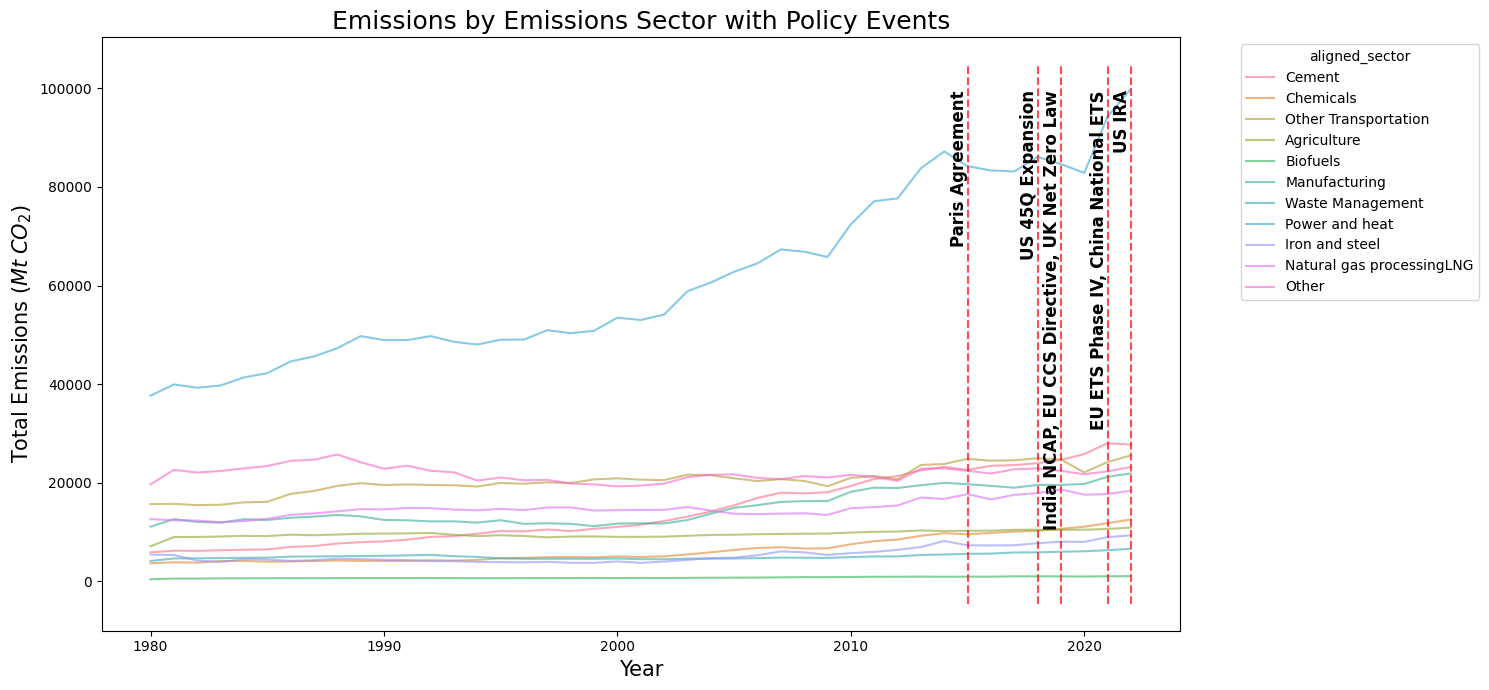

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_by_sector_with_policies(
    df,
    value_col='Value',
    sector_col='Sector',
    year_col='Year',
    policy_dates=None,
    ylabel='Value',
    title='Trends by Sector'
):
    # Prepare a clean dict of scalar policy years
    clean_policies = {}
    if policy_dates:
        for event, yr in policy_dates.items():
            # Force into a 1D numpy array then take its first element
            yr_arr = np.atleast_1d(yr)
            yr0 = yr_arr[0] if yr_arr.size > 0 else np.nan
            # Coerce to numeric, invalid → NaN
            yr_num = pd.to_numeric(yr0, errors='coerce')  # :contentReference[oaicite:0]{index=0}
            # Keep only finite values
            if np.isfinite(yr_num):                       # :contentReference[oaicite:1]{index=1}
                clean_policies[event] = float(yr_num)
    policy_dates = clean_policies

    plt.figure(figsize=(12, 7))
    ax = sns.lineplot(
        data=df,
        x=year_col,
        y=value_col,
        hue=sector_col,
        ci=None,
        #errorbar='sd',         # standard-deviation bands :contentReference[oaicite:2]{index=2}
        legend='full',
        alpha=0.6
    )

    # Annotate policy dates with vertical lines (data coordinates)
    ymin, ymax = ax.get_ylim()
    for event, yr in policy_dates.items():
        ax.vlines(x=yr, ymin=ymin, ymax=ymax,
                  color='red', linestyle='--', alpha=0.7)  # :contentReference[oaicite:3]{index=3}
        ax.text(yr, ymax * 0.95, event, rotation=90,
                va='top', ha='right', fontsize=12, color='black', fontweight='bold')

    ax.set_xlabel(year_col, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_title(title, fontsize=18)
    plt.tight_layout()
    plt.legend(title=sector_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

updated_policy_dates = {
    'Paris Agreement': 2015,
    'EU ETS Phase IV, China National ETS': 2021,
    'US 45Q Expansion': 2018,
    #'EU CBAM, Japan GX League': 2023,
    'US IRA': 2022,
    'India NCAP, EU CCS Directive, UK Net Zero Law': 2019,
}

plot_by_sector_with_policies(
     df_merged_cleaned,
     value_col='Emissions',
     sector_col='aligned_sector',
     year_col='Year', 
     policy_dates=updated_policy_dates,
     ylabel=r'Total Emissions ($Mt \; CO_2$)', 
     title='Emissions by Emissions Sector with Policy Events'
 )


In [ ]:
sns.set_theme()

C:\Users\rjsou\AppData\Local\Temp\ipykernel_16132\947214858.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(


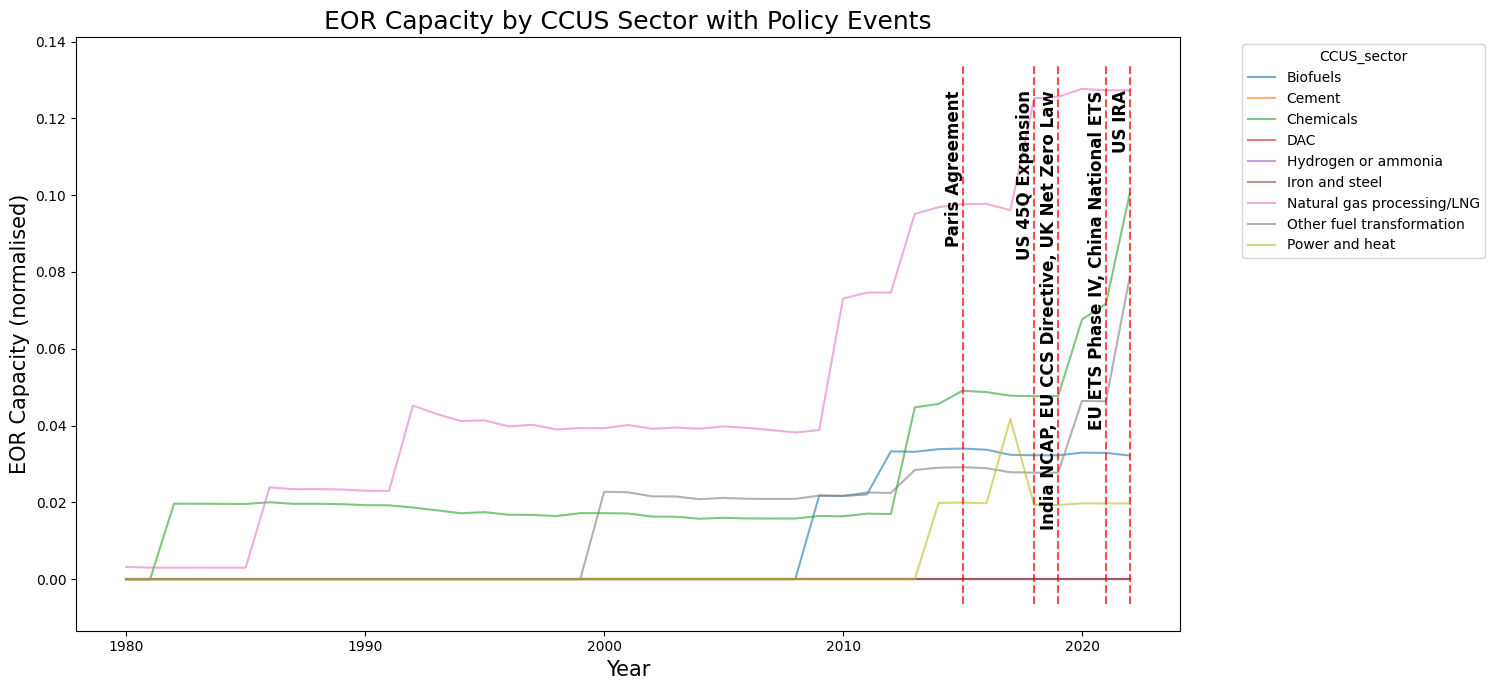

In [117]:
plot_by_sector_with_policies(
     df_merged_cleaned,
     value_col='eor_capacity_norm',
     sector_col='CCUS_sector',
     year_col='Year', 
     policy_dates=updated_policy_dates,
     ylabel='EOR Capacity (normalised)', 
     title='EOR Capacity by CCUS Sector with Policy Events'
 )

In [115]:
crosswalk = {
    'Cement production': 'Cement',
    'Chemical Industry': 'Chemicals',
    'Civil Aviation': 'Other Transportation',  # Consider a new "Aviation" CCUS sector if this is a key focus
    'Direct N2O Emissions from managed soils': 'Agriculture',  # Or consider "Other"
    'Emissions from biomass burning': 'Biofuels',
    'Enteric Fermentation': 'Agriculture',
    'Glass Production': 'Manufacturing',
    'Incineration and Open Burning of Waste': 'Waste Management',
    'Indirect N2O Emissions from managed soils': 'Agriculture',
    'Indirect N2O Emissions from manure management': 'Agriculture',
    'Indirect N2O emissions from the atmospheric deposition of nitrogen in NOx and NH3': 'Agriculture',  # Or "Other"
    'Lime production': 'Manufacturing',
    'Liming': 'Agriculture',
    'Main Activity Electricity and Heat Production': 'Power and heat',
    'Manufacturing Industries and Construction': 'Manufacturing',
    'Manure Management': 'Agriculture',
    'Metal Industry': 'Iron and steel',
    'Non-Energy Products from Fuels and Solvent Use': 'Chemicals',
    'Oil and Natural Gas': 'Natural gas processingLNG',
    'Other Process Uses of Carbonates': 'Manufacturing',
    'Other Product Manufacture and Use': 'Manufacturing',
    'Other Transportation': 'Other Transportation',
    'Petroleum Refining - Manufacture of Solid Fuels and Other Energy Industries': 'Natural gas processingLNG',
    'Product Uses as Substitutes for Ozone Depleting Substances': 'Chemicals',  # Or "Manufacturing"
    'Residential and other sectors': 'Other',
    'Rice cultivations': 'Agriculture',
    'Road Transportation no resuspension': 'Other Transportation',
    'Solid Fuels': 'Power and heat',
    'Solid Waste Disposal': 'Waste Management',
    'Urea application': 'Agriculture',
    'Wastewater Treatment and Discharge': 'Waste Management',
    'Water-borne Navigation': 'Other Transportation',
    'Railways': 'Other Transportation',
    'Biological Treatment of Solid Waste': 'Waste Management',
    'Electronics Industry': 'Manufacturing',
    'Fossil fuel fires': 'Power and heat',
    'Non-Specified': 'Other'
}

# apply on dataframe

df_merged_cleaned['aligned_sector'] = df_merged_cleaned['emissions_sector'].map(crosswalk)



In [ ]:
def continuous_event_study(
    df,
    outcome_var='d_log_emissions',
    treat_var='d_log_eor_capacity',
    country_var='Country',
    ccus_var='CCUS_sector',
    year_var='Year',
    start_year=2012,
    pre=5,
    post=10
):
    df = df.copy()
    
    # 1) Compute event time and filter
    df[year_var] = pd.to_numeric(df[year_var], errors='coerce')
    df['event_time'] = df[year_var] - start_year
    df = df[(df['event_time'] >= -pre) & (df['event_time'] <= post)].copy()

    # 2) Create valid parameter names using n for negative
    es_params = []
    for k in range(-pre, post+1):
        # Convert negative to e.g. "att_n5" instead of "att_-5"
        param_name = f"att_n{abs(k)}" if k < 0 else f"att_{k}"
        df[param_name] = (df['event_time'] == k) * df[treat_var]
        es_params.append(param_name)

    # 3) Simplified FE structure
    fe_terms = [
        f"C({country_var})", 
        f"C({year_var})",
        f"C({ccus_var})",
        #"C(emissions_sector)"
    ]
    
    # 4) Build formula with valid names
    formula = f"{outcome_var} ~ {' + '.join(es_params)} + {' + '.join(fe_terms)}"

    # 5) Fit model with two-way clustering
    model = smf.ols(formula, data=df).fit()
    
    # Cluster by country and CCUS sector
    g1 = pd.Categorical(df[country_var]).codes
    g2 = pd.Categorical(df[ccus_var]).codes
    cov = cov_cluster_2groups(model, g1, g1)
    model.cov_params_default = cov

    # 6) PTA test on pre-period coefficients
    pre_terms = [f"att_n{abs(k)}" for k in range(-pre, 0)]
    ftest = model.f_test(pre_terms)

    # 7) Extract event study estimates
    att_data = []
    for k in range(-pre, post+1):
        param_name = f"att_n{abs(k)}" if k < 0 else f"att_{k}"
        if param_name in model.params:
            att_data.append({
                'event_time': k,
                'att': model.params[param_name],
                'se': model.bse[param_name],
                'pval': model.pvalues[param_name]
            })
    att_df = pd.DataFrame(att_data)

    return {
        'pta_passed': ftest.pvalue > 0.05,
        'f_stat': ftest.fvalue,
        'pta_pvalue': ftest.pvalue,
        'n_obs': int(model.nobs),
        'n_countries': df[country_var].nunique(),
        'att_df': att_df,
        'model': model
    }, df

results, event_df = continuous_event_study(
    df=focused_df,
    outcome_var='d_log_emissions',
    treat_var='log_eor_capacity',
    start_year=2012,
    pre=5,
    post=10
)


In [ ]:
import statsmodels.formula.api as smf
formula = 'd_log_emissions ~ log_eor_capacity + C(Country) + C(CCUS_sector) + C(emissions_sector) + C(Year)'
model = smf.ols(formula, data=focused_df)
res = model.fit(cov_type='cluster', cov_kwds={'groups': focused_df['Country']})
print(res.summary())


In [4]:
__main__

NameError: name '__main__' is not defined

In [279]:
(focused_df['d_log_eor_capacity'] > 0.4).any()

np.True_

In [296]:
# Identify first treatment year for each panel (only where treatment is nonzero)
treatments = focused_df[focused_df['d_log_eor_capacity'] != 0].copy()
first_treat = (treatments
               .groupby(['Country','CCUS_sector','emissions_sector','Sector'])['Year']
               .min()
               .reset_index()
               .rename(columns={'Year': 'first_treat_year'}))

# Merge back to the original data
df = pd.merge(focused_df, first_treat, on=['Country','CCUS_sector','emissions_sector','Sector'], how='left')

# Compute event time: year relative to first treatment year
df['event_time'] = df['Year'] - df['first_treat_year']

# (Optional) Display first few rows with event_time
print(df[['Country','Year','first_treat_year','event_time','d_log_eor_capacity']].head(10))


  Country  Year  first_treat_year  event_time  d_log_eor_capacity
0  Canada  1980            2020.0       -40.0                 0.0
1  Canada  1980               NaN         NaN                 0.0
2  Canada  1980               NaN         NaN                 0.0
3  Canada  1980               NaN         NaN                 0.0
4  Canada  1980               NaN         NaN                 0.0
5  Canada  1980               NaN         NaN                 0.0
6  Canada  1980               NaN         NaN                 0.0
7  Canada  1980               NaN         NaN                 0.0
8  Canada  1980               NaN         NaN                 0.0
9  Canada  1980               NaN         NaN                 0.0


In [297]:
df['event_time'].unique()

array([-40.,  nan, -39., -38., -37., -36., -35., -34., -33., -32., -31.,
       -30., -29., -28., -27., -26., -25., -24., -23., -22., -21., -20.,
       -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,
        -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,
         3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.])

In [298]:
df = df[(df['event_time'] >= -5) & (df['event_time'] <= 10)].copy()

In [258]:
print(f"Data filtered to event_time ∈ [{-5}, {10}]: {df.shape[0]} observations remain.")

Data filtered to event_time ∈ [-5, 10]: 10439 observations remain.


In [299]:
# Define event time indicators and interactions (exclude k = -1 as base)
interaction_terms = []
pre_period = -3
post_period = 10
for k in range(pre_period, post_period+1):
    if k == -1:
        continue  # omit event_time = -1 as baseline
    # Create dummy for event time k
    suffix = f"n{-k}" if k < 0 else f"{k}"
    df[f'att_{suffix}'] = (df['event_time'] == k).astype(int)
    # Interaction with continuous treatment dose
    df[f'dose_att_{suffix}'] = df[f'att_{suffix}'] * df['d_log_eor_capacity']
    interaction_terms.append(f'dose_att_{suffix}')

print("Created event-time interaction terms:", interaction_terms[:5], "...", interaction_terms[-5:])


Created event-time interaction terms: ['dose_att_n3', 'dose_att_n2', 'dose_att_0', 'dose_att_1', 'dose_att_2'] ... ['dose_att_6', 'dose_att_7', 'dose_att_8', 'dose_att_9', 'dose_att_10']


In [319]:
# List of fixed effect variables
fe_vars = ['Country', 'Year', 'Sector']
# Build the regression formula
formula = 'd_log_emissions ~ ' + ' + '.join(interaction_terms) \
          + ' + C(Country) + C(Year)'

# Fit the model with cluster-robust SE by Country
model = smf.ols(formula, data=df).fit(
)

print(model.summary().tables[1])


                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                   -5.716e-12      5.107  -1.12e-12      1.000     -10.009      10.009
C(Country)[T.China]         -3.475e-15      1.704  -2.04e-15      1.000      -3.340       3.340
C(Country)[T.United States]  6.432e-16      1.703   3.78e-16      1.000      -3.338       3.338
C(Year)[T.1981]              5.715e-12      4.824   1.18e-12      1.000      -9.455       9.455
C(Year)[T.1982]              5.715e-12      4.824   1.18e-12      1.000      -9.455       9.455
C(Year)[T.1983]              5.717e-12      4.824   1.19e-12      1.000      -9.455       9.455
C(Year)[T.1984]              5.716e-12      4.824   1.18e-12      1.000      -9.455       9.455
C(Year)[T.1985]              5.716e-12      4.824   1.18e-12      1.000      -9.455       9.455
C(Year)[T.1986]              5.715e-12  

C:\Users\rjsou\AppData\Local\Temp\ipykernel_5556\2820695518.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


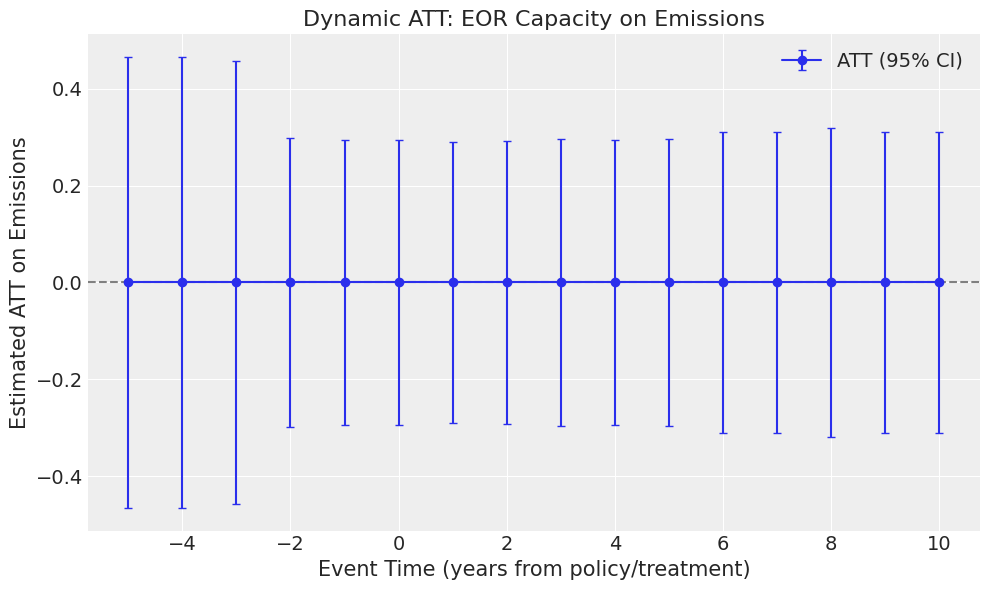

In [320]:
plot_event_study(results['att_df'], title="Dynamic ATT: EOR Capacity on Emissions")

In [67]:
df_merged_cleaned.to_csv('ds.csv')

In [253]:
import numpy.random as npr

# Extract original fitted values and residuals
y_pred = model.fittedvalues
resid = model.resid

# Map each observation to its country cluster index
clusters = df['Country'].astype('category')
cluster_indices = clusters.cat.codes.values
unique_countries = clusters.cat.categories

n_clusters = len(unique_countries)
B = 500  # Number of bootstrap reps (increase for real analysis)
boot_coefs = np.zeros((B, len(interaction_terms)))

for b in tqdm(range(B)):
    # Draw random sign for each country
    signs = npr.choice([-1, 1], size=n_clusters)
    # Apply wild bootstrap to residuals
    resid_boot = resid.copy()
    for j in range(n_clusters):
        idx = (cluster_indices == j)
        resid_boot[idx] *= signs[j]
    # Create new outcome
    df['d_log_emissions_boot'] = y_pred + resid_boot
    # Re-fit with bootstrap outcome
    boot_model = smf.ols(formula.replace('d_log_emissions', 'd_log_emissions_boot'),
                         data=df).fit()
    boot_coefs[b, :] = boot_model.params[interaction_terms].values

# Compute p-values for original coefficients (two-tailed)
orig_coefs = model.params[interaction_terms].values
p_values = []
for k, coef in enumerate(orig_coefs):
    boot_dist = boot_coefs[:, k]
    # Two-tailed p-value: proportion of boot coefs more extreme than original
    p_val = np.mean(np.abs(boot_dist) >= np.abs(coef))
    p_values.append(p_val)

# Display bootstrap p-values for each event-time coefficient
for term, coef, p in zip(interaction_terms, orig_coefs, p_values):
    print(f"{term}: coef={coef:.3f}, p(wild-boot)={p:.3f}")


100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [03:24<00:00,  2.44it/s]

dose_att_n3: coef=0.000, p(wild-boot)=0.496
dose_att_n2: coef=0.000, p(wild-boot)=0.748
dose_att_0: coef=-0.000, p(wild-boot)=0.612
dose_att_1: coef=-0.000, p(wild-boot)=1.000
dose_att_2: coef=-0.000, p(wild-boot)=1.000
dose_att_3: coef=0.000, p(wild-boot)=1.000
dose_att_4: coef=0.000, p(wild-boot)=0.748
dose_att_5: coef=-0.000, p(wild-boot)=0.506
dose_att_6: coef=-0.000, p(wild-boot)=0.254
dose_att_7: coef=0.000, p(wild-boot)=0.506
dose_att_8: coef=0.000, p(wild-boot)=0.748
dose_att_9: coef=0.000, p(wild-boot)=0.748
dose_att_10: coef=0.000, p(wild-boot)=0.748


In [254]:
# Build contrast matrix for joint test that pre-event coefs = 0
pre_terms = [t for t in interaction_terms if 'att_n' in t]  # e.g., ['dose_att_n5',...,'dose_att_n2']
pre_terms = [t for t in pre_terms if int(t.split('_n')[-1]) >= 2]  # ensure we have 2,3,4,5
print("Pre-event terms included in joint test:", pre_terms)

# Formulate F-test string for statsmodels
test_str = ' = 0, '.join(pre_terms) + ' = 0'
f_test = model.f_test(test_str)
print("F-stat for pre-trends test:", f_test.fvalue, "p-value:", f_test.pvalue)


Pre-event terms included in joint test: ['dose_att_n3', 'dose_att_n2']
F-stat for pre-trends test: 1622.0664213944788 p-value: 0.0006161177304998011


# Testing

In [144]:
df_merged_cleaned.columns

Index(['Year', 'Country', 'Sector', 'Demand_coal_peat_and_oil_shale',
       'Demand_crude_ngl_and_feedstocks', 'Demand_electricity', 'Demand_heat',
       'Demand_natural_gas', 'Demand_nuclear', 'Demand_oil_products',
       'Demand_renewables_and_waste', 'Demand_total', 'Supply_fossil_fuels',
       'Supply_nuclear', 'Supply_renewable_sources', 'Supply_total',
       'CCUS_sector', 'dedicated_storage_capacity', 'eor_capacity',
       'use_capacity', 'unknown_capacity', 'mixed_co2_capacity',
       'total_capacity', 'emissions_sector', 'fossil_bio', 'Emissions',
       'Population', 'CPI_growth', 'GDP_PPP', 'GDP_per_capita_PPP', 'OECD',
       'log_emissions', 'd_log_emissions', 'd_log_emissions_norm',
       'emissions_norm', 'log_dedicated_storage_capacity',
       'd_log_dedicated_storage_capacity',
       'd_log_dedicated_storage_capacity_norm', 'log_eor_capacity',
       'd_log_eor_capacity', 'd_log_eor_capacity_norm', 'log_use_capacity',
       'd_log_use_capacity', 'd_log_use_c

In [222]:
# Residualization approach for supply_nuclear and economic_index
from sklearn.linear_model import LinearRegression

# 1. Residualize supply_nuclear with respect to economic_index
model = LinearRegression()
X = df_merged_cleaned[['GDP_per_capita_PPP']].values.reshape(-1, 1)  # Predictor
y = df_merged_cleaned['Supply_nuclear']  # Variable to residualize

model.fit(X, y)
predicted = model.predict(X)
df_merged_cleaned['supply_nuclear_residualized'] = y - predicted


model = LinearRegression()
X = df_merged_cleaned[['energy_demand_fossil_fuels']].values.reshape(-1, 1)  # Predictor
y = df_merged_cleaned['Demand_nuclear']  # Variable to residualize

model.fit(X, y)
predicted = model.predict(X)
df_merged_cleaned['Demand_nuclear_residualized'] = y - predicted

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.sandwich_covariance import cov_cluster_2groups

# Load and subset data
df = pd.read_csv('df_merged_cleaned.csv').copy()

# Focus on countries and sectors with highest treatment density
subset_countries = ['United States', 'Canada', 'China']
subset_ccus_sectors = ['Natural gas processing/LNG', 'Chemicals', 'Biofuels']

df_subset = df[
    (df['Country'].isin(subset_countries)) & 
    (df['CCUS_sector'].isin(subset_ccus_sectors))
].copy()

# Create variables for different methods
df_subset['post'] = (df_subset['Year'] >= 2012).astype(int)  # Paris Agreement as treatment
df_subset['treated'] = (df_subset['eor_capacity'] > 0).astype(int)
df_subset['did'] = df_subset['post'] * df_subset['treated']
df_subset['continuous_did'] = df_subset['post'] * df_subset['d_log_eor_capacity']

high_het = pd.read_csv('high_heterogeneity.csv')
high_het_combos = high_het[['Country', 'CCUS_sector', 'emissions_sector', 'Sector']].drop_duplicates()
df_filtered = pd.merge(df_subset, high_het_combos, 
                      on=['Country', 'CCUS_sector', 'emissions_sector', 'Sector'], 
                      how='inner')


In [94]:
df_filtered.to_csv('ds_test.csv')

In [65]:
fixed_effects = [
    'Country',
    'CCUS_sector',
    'Sector',
    'emissions_sector'
]

analytic_vars = [
    'Demand_electricity', 'Demand_heat',
    'Demand_nuclear', #'Demand_oil_products',
    'Demand_renewables_and_waste',
    #'Supply_nuclear',
    'Supply_nuclear', #'eor_capacity',
    'renewable_to_fossil_supply_ratio',
    'energy_demand_fossil_fuels',
    'CPI_growth',
    #'dedicated_storage_capacity', 'eor_capacity',
    #'use_capacity', 'unknown_capacity', 'mixed_co2_capacity',
    #'total_capacity', 'emissions_sector', 'fossil_bio',
    'GDP_per_capita_PPP',
    'd_log_eor_capacity'
   # 'd_log_eor_capacity',
    #'d_log_emissions',
    #'d_log_use_capacity_norm', 'd_log_unknown_capacity_norm',
    #'d_log_mixed_co2_capacity_norm',
    #'energy_demand_ratio_fossil_low_carbon'
]

In [181]:
analytic_vars

['Demand_electricity',
 'supply_nuclear_residualized',
 'eor_capacity',
 'renewable_to_fossil_supply_ratio',
 'energy_demand_fossil_fuels',
 'CPI_growth',
 'GDP_per_capita_PPP',
 'energy_demand_ratio_fossil_low_carbon']

In [66]:
get_VIF_values(df_filtered, analytic_vars)

,Variable,VIF
0,const,18.070704
3,Demand_nuclear,4.693429
7,energy_demand_fossil_fuels,4.002470
9,GDP_per_capita_PPP,3.859195
5,Supply_nuclear,3.848790
1,Demand_electricity,3.335809
2,Demand_heat,1.533627
6,renewable_to_fossil_supply_ratio,1.505526
8,CPI_growth,1.274043
4,Demand_renewables_and_waste,1.243427


In [189]:
df_merged_cleaned['dedicated_storage_capacity'].sum()/df_merged_cleaned['total_capacity'].sum()

np.float64(0.05264661197108649)

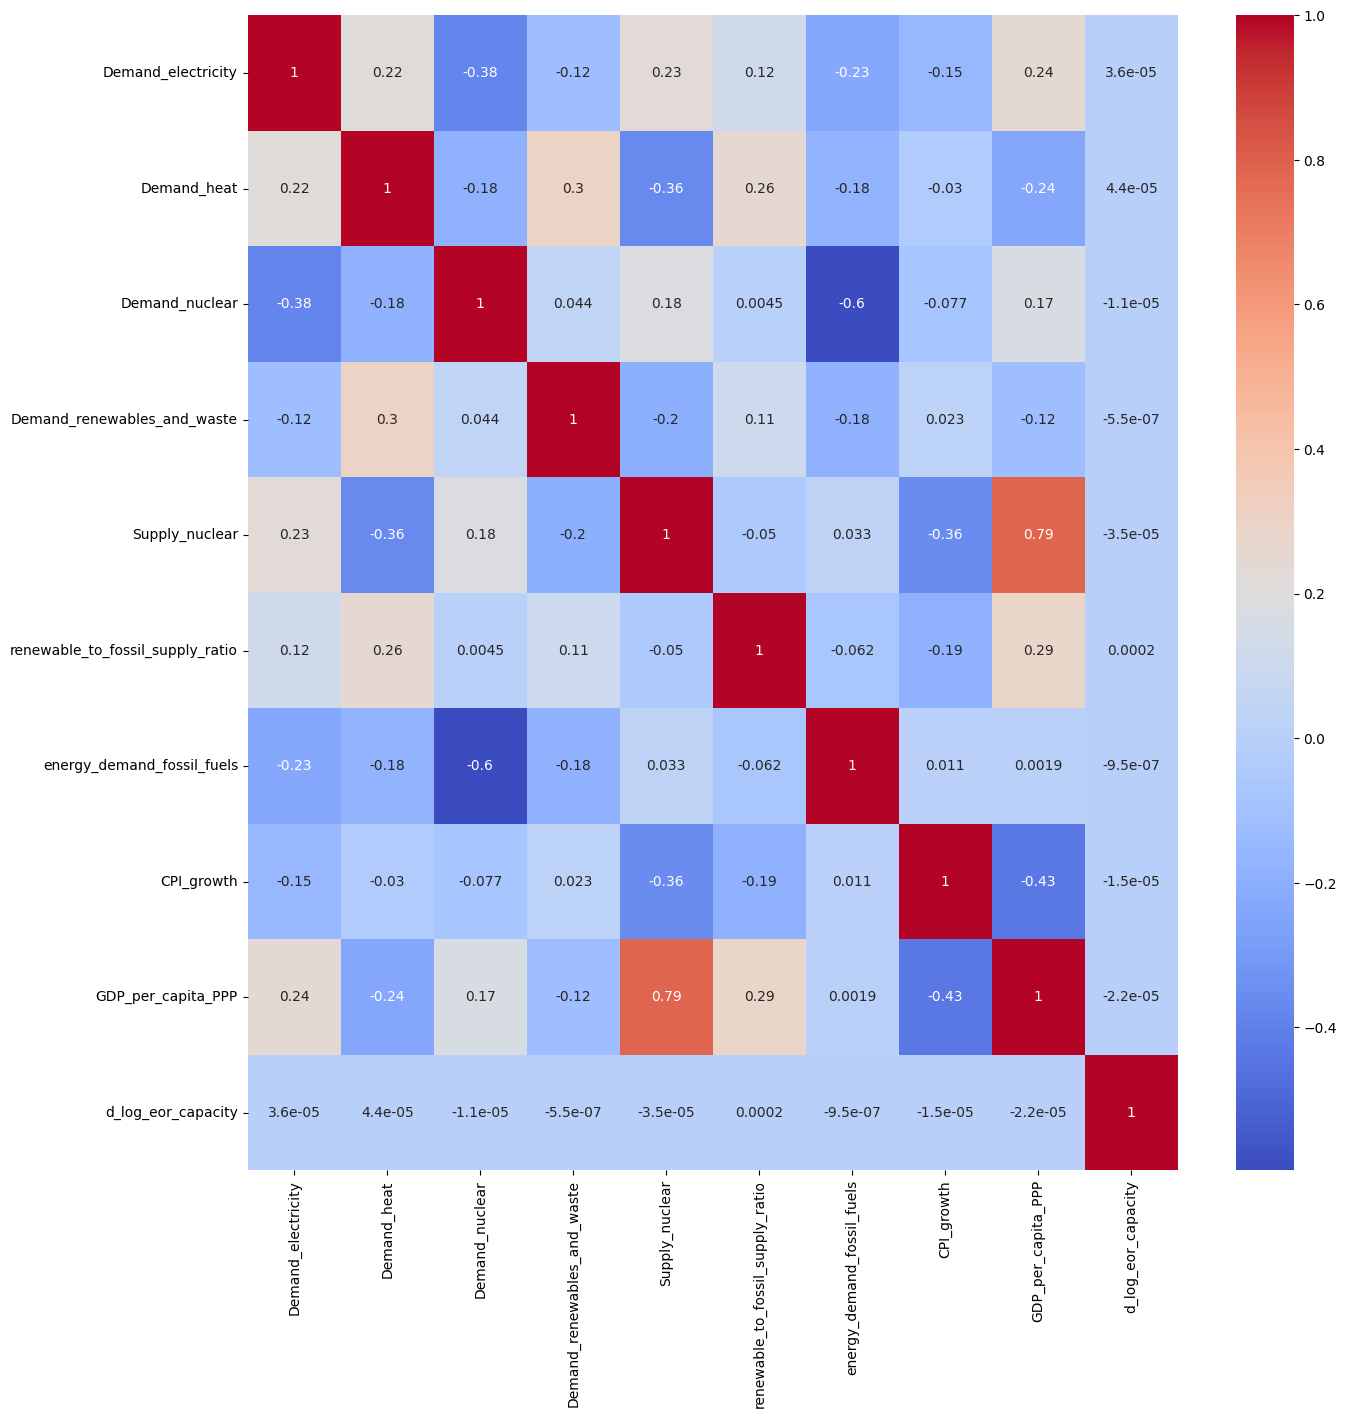

In [205]:
interest_columns = [
    'Demand_electricity', 'Demand_heat',
    'Demand_nuclear_residualised', #'Demand_oil_products',
    #'Demand_renewables_and_waste',
    #'Supply_nuclear',
    'supply_nuclear_residualized', #'eor_capacity',
    'renewable_to_fossil_supply_ratio',
    'energy_demand_fossil_fuels',
    'CPI_growth',
    #'dedicated_storage_capacity', 'eor_capacity',
    #'use_capacity', 'unknown_capacity', 'mixed_co2_capacity',
    #'total_capacity', 'emissions_sector', 'fossil_bio',
    'GDP_per_capita_PPP',
    #'d_log_emissions', 'd_log_eor_capacity',
    #'d_log_use_capacity_norm', 'd_log_unknown_capacity_norm',
    #'d_log_mixed_co2_capacity_norm',
    #'energy_demand_ratio_fossil_low_carbon'
]

get_correlation_matrix(df_filtered, analytic_vars)

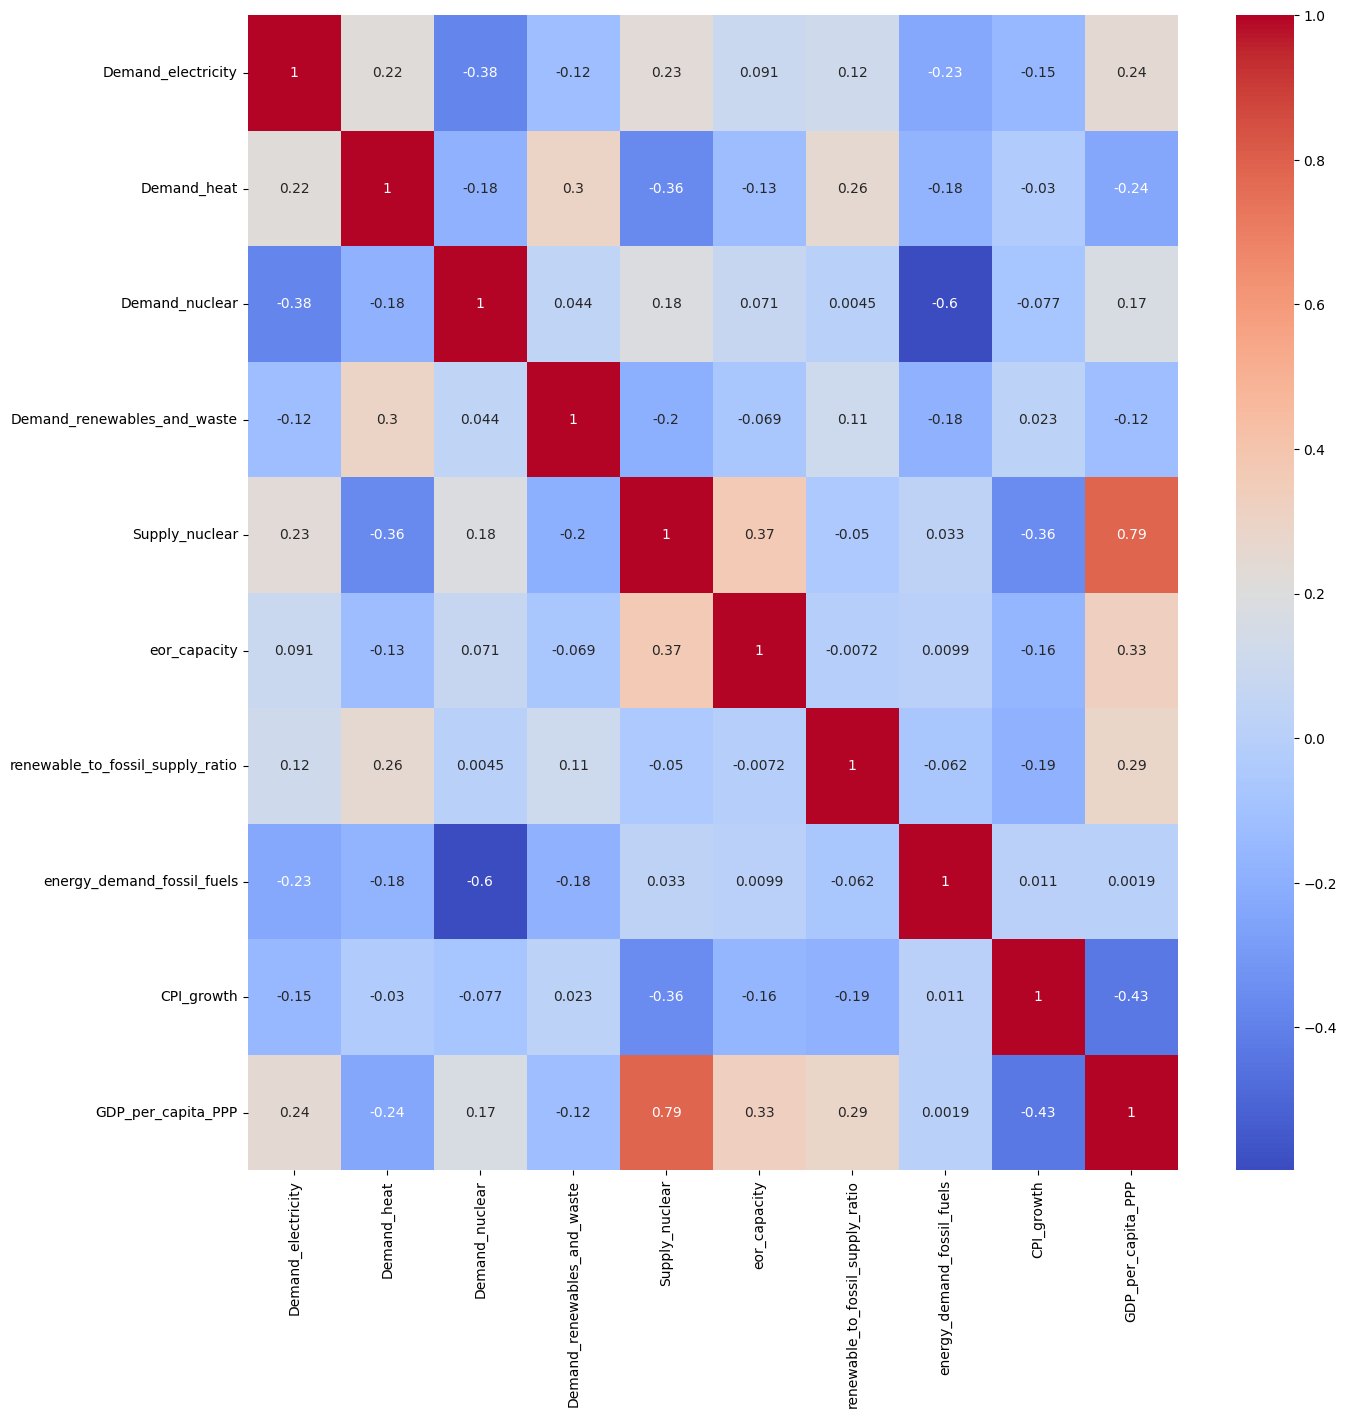

In [149]:
interest_columns = [
    'Demand_electricity', 'Demand_heat',
    'Demand_nuclear', #'Demand_oil_products',
    'Demand_renewables_and_waste',
    'Supply_nuclear', 'eor_capacity',
    'renewable_to_fossil_supply_ratio',
    'energy_demand_fossil_fuels',
    'CPI_growth',
    #'dedicated_storage_capacity', 'eor_capacity',
    #'use_capacity', 'unknown_capacity', 'mixed_co2_capacity',
    #'total_capacity', 'emissions_sector', 'fossil_bio',
    'GDP_per_capita_PPP',
    #'d_log_emissions', 'd_log_eor_capacity',
    #'d_log_use_capacity_norm', 'd_log_unknown_capacity_norm',
    #'d_log_mixed_co2_capacity_norm',
]

get_correlation_matrix(df_filtered, interest_columns)

In [68]:
df_filtered.to_csv('ds_fil_test.csv')

In [1]:
treatment_ratio = (df_merged_cleaned['d_log_eor_capacity'] > 0).mean()
print(f"Treatment ratio in focused subset: {treatment_ratio:.2%}")

NameError: name 'df_merged_cleaned' is not defined

In [102]:
# Focus on high-treatment regions to increase signal-to-noise ratio
df_filtered = df_merged_cleaned[  
    (df_merged_cleaned['Country'].isin(['United States', 'Canada', 'China'])) &  
    (df_merged_cleaned['CCUS_sector'].isin([  
        'Natural gas processing/LNG',  
        'Chemicals',  
        'Biofuels'  
    ]))  
]  

# Recalculate treatment coverage
treatment_ratio = (df_filtered['d_log_eor_capacity'] > 0.4).mean()
print(f"Treatment ratio in focused subset: {treatment_ratio:.2%}")


Treatment ratio in focused subset: 7.52%


In [94]:
from linearmodels.panel import PanelOLS

"""# Create a combined entity identifier from Country and Sector
df_filtered['entity'] = df_filtered['Country'] + ' - ' + df_filtered['Sector']

# Set MultiIndex with entity (Country-Sector) and time (Year)
df_filtered = df_filtered.set_index(['Country', 'Year'])
"""
# Define dependent and independent variables (adjust names to match your actual columns)
# Assuming 'energy_demand_fossil_fuels' is your emissions proxy and 'eor_capacity_norm' is your EOR capacity
y = df_filtered['d_log_emissions']  # Dependent variable (d_log_emissions equivalent)
X = df_filtered[['d_log_eor_capacity']]         # Independent variable (d_log_eor_capacity equivalent)

# Specify the model with fixed effects
mod = PanelOLS(y, X, entity_effects=True, time_effects=True)

# Fit with clustered standard errors
res = mod.fit(cov_type='clustered', cluster_entity=True)

print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:        d_log_emissions   R-squared:                     2.646e-12
Estimator:                   PanelOLS   R-squared (Between):           -1.92e-07
No. Observations:              149370   R-squared (Within):            2.638e-12
Date:                Thu, May 01 2025   R-squared (Overall):           2.624e-12
Time:                        13:23:49   Log-likelihood                -4.461e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.951e-07
Entities:                           3   P-value                           0.9995
Avg Obs:                    4.979e+04   Distribution:                F(1,149324)
Min Obs:                    3.031e+04                                           
Max Obs:                    6.887e+04   F-statistic (robust):          2.526e+04
                            

In [ ]:
df_merged_cleaned.groupby(['CCUS_sector', 'OECD']).plot(kind='bar', x='CCUS_sector', y='eor_capacity')

AttributeError: 'DataFrame' object has no attribute 'bar'

In [104]:
df = df_filtered.copy()
df['treated'] = df['d_log_eor_capacity'] > 0.1  # example threshold
df['first_treat_year'] = df.groupby(['Country', 'Year'])['Year'].transform(
    lambda x: x[df.loc[x.index, 'treated']].min()
)
df['event_time'] = df['Year'] - df['first_treat_year']


from linearmodels.panel import PanelOLS
import patsy

# Create event_time dummies (omit baseline, e.g., event_time = -1)
dummies = patsy.dmatrix('C(event_time_binned)', df, return_type='dataframe')
dummies = dummies.loc[:, dummies.columns != 'C(event_time_binned)[-1.0]']  # omit base

X = dummies
y = df['d_log_emissions']
mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
res.summary

import matplotlib.pyplot as plt

coefs = res.params
se = res.std_errors
event_times = [int(col.split('[')[1].split(']')[0]) for col in coefs.index]

plt.errorbar(event_times, coefs, yerr=1.96*se, fmt='o')
plt.axhline(0, linestyle='--')
plt.xlabel('Event Time (Years relative to treatment)')
plt.ylabel('Effect on log emissions')
plt.title('Event Study: Parallel Trends Check')
plt.show()


PatsyError: Error evaluating factor: NameError: name 'event_time_binned' is not defined
    C(event_time_binned)
    ^^^^^^^^^^^^^^^^^^^^

In [97]:
plot_event_study(res['att_df'], title="Dynamic ATT: EOR Capacity on Emissions")

TypeError: 'PanelEffectsResults' object is not subscriptable

# PTA

In [83]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.sandwich_covariance import cov_cluster_2groups

def pta_event_study(
    df,
    outcome_var='d_log_emissions',
    treat_var='delta_treatment',
    country_var='Country',
    ccus_var='CCUS_sector',
    year_var='Year',
    start_year=2012,
    pre=5,
    post=10
):
    """
    Run a dose–response event‐study and test parallel‐trends via joint F‐test
    of all pre‐treatment interaction terms.

    Returns dict with: pta_passed, F, p‐value, n_obs, n_countries, pre_coefs.
    """
    df = df.copy()
    # 1) Compute event time
    df[year_var] = pd.to_numeric(df[year_var], errors='coerce')
    df['event_time'] = df[year_var] - start_year

    # 2) Restrict to event window
    df = df[(df['event_time'] >= -pre) & (df['event_time'] <= post)].copy()

    # 3) Build pre‐treatment interactions Δtreatment × I{event_time = k} for k = –pre … –1
    pre_names = []
    for k in range(-pre, 0):
        name = f"pre_{abs(k)}"
        df[name] = (df['event_time'] == k).astype(int) * df[treat_var]
        pre_names.append(name)

    # 4) Define formula: outcome ~ pre_terms + fixed effects
    fe = " + ".join([
        f"C({country_var})",
        f"C({year_var})",
        f"C({ccus_var})",
        "C(Sector)",            # if you have a main sector column
        "C(emissions_sector)"
    ])
    formula = f"{outcome_var} ~ {' + '.join(pre_names)} + {fe}"

    # 5) Fit unrestricted model
    m = smf.ols(formula, data=df).fit()

    # 6) Overwrite covariance with two-way cluster (country × CCUS_sector)
    #    cov_both = cluster‐by‐country + cluster‐by‐ccus – cluster‐by‐intersection
    g1 = pd.Categorical(df[country_var]).codes
    g2 = pd.Categorical(df[ccus_var]).codes
    cov_both, _, _ = cov_cluster_2groups(m, g1, g2, use_correction=True)
    m.cov_params_default = cov_both

    # 7) Joint F‐test of H0: all pre_k = 0
    #    Supply plain strings: ["pre_1 = 0", "pre_2 = 0", …]
    constraints = [f"{name} = 0" for name in pre_names]
    ft = m.f_test(constraints)  # plain‐string list syntax :contentReference[oaicite:2]{index=2}

    att_df = pd.DataFrame({
        'event_time': [k for k in range(-pre, post+1)],
        'att': [m.params.get(f"att_{k}", np.nan) for k in range(-pre, post+1)],
        'se': [m.bse.get(f"att_{k}", np.nan) for k in range(-pre, post+1)]
    })

    # 8) Return results
    return {
        'pta_passed': (ft.pvalue > 0.05),
        'f_stat':     float(ft.fvalue),
        'p_value':    float(ft.pvalue),
        'n_obs':      int(m.nobs),
        'n_countries': int(df[country_var].nunique()),
        'pre_coefs':  m.params[pre_names].to_dict(),
        'att_df':     att_df
    }, df


# --- Example Usage ---
results, event_df = pta_event_study(
    df=df_merged_cleaned,
    outcome_var='d_log_emissions',   # or 'd_log_emissions'
    treat_var='d_log_eor_capacity',
    country_var='Country',
    year_var='Year',
    start_year=2017,
    pre=5,
    post=5
)

print("PTA Test:", "PASSED" if results['pta_passed'] else "FAILED")
print(f"  F-stat = {results['f_stat']:.2f}, p-value = {results['p_value']:.3f}")
print(f"  Observations: {results['n_obs']}, Countries: {results['n_countries']}")


PTA Test: PASSED
  F-stat = 0.00, p-value = 1.000
  Observations: 1245228, Countries: 51


In [150]:
df_merged_cleaned

,Year,Country,Sector,Demand_coal_peat_and_oil_shale,Demand_crude_ngl_and_feedstocks,Demand_electricity,Demand_heat,Demand_natural_gas,Demand_nuclear,Demand_oil_products,...,d_log_use_capacity_norm,log_unknown_capacity,d_log_unknown_capacity,d_log_unknown_capacity_norm,log_mixed_co2_capacity,d_log_mixed_co2_capacity,d_log_mixed_co2_capacity_norm,eor_capacity_norm,energy_demand_fossil_fuels,renewable_to_fossil_supply_ratio
2704962,1998,Argentina,Commercial and public services (PJ),0.000000,0.000000,0.533026,0.0,0.378660,0.000000,0.065336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.665911,1.004088
2705295,1998,Argentina,Industry (PJ),0.031243,0.000000,0.234837,0.0,0.552509,0.000000,0.068998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.160424,1.004088
2705628,1998,Argentina,Other final consumption (PJ),0.005260,0.000000,0.007892,0.0,0.031014,0.000000,0.955833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.631369,1.004088
2705961,1998,Argentina,Residential (PJ),0.000000,0.000000,0.198171,0.0,0.614673,0.000000,0.144264,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.092075,1.004088
2706294,1998,Argentina,Total energy supply (PJ),0.013346,0.497492,0.011478,0.0,0.446032,0.032395,-0.081706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.458626,1.004088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463393,2022,United States,Residential (PJ),0.000000,0.000000,0.470032,0.0,0.422666,0.000000,0.053804,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.789294,0.355708
5464312,2022,United States,Total energy supply (PJ),0.110094,0.437842,0.001631,0.0,0.354941,0.096366,-0.089171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.370865,0.355708
5464313,2022,United States,Total energy supply (PJ),0.110094,0.437842,0.001631,0.0,0.354941,0.096366,-0.089171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.370865,0.355708
5465232,2022,United States,Transport (PJ),0.000000,0.000000,0.002326,0.0,0.048512,0.000000,0.889032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.493263,0.355708


In [136]:
treat_col = 'd_log_eor_capacity'  # or your treatment variable
df = df_merged_cleaned.copy()
print("Total rows:", len(df))
print("Rows with nonzero treatment:", (df[treat_col] != 0).sum())
print("Proportion nonzero:", (df[treat_col] != 0).mean())
print("Years with any treatment:", df[df[treat_col] != 0]['Year'].unique())
print("Sectors with any treatment:", df[df[treat_col] != 0]['CCUS_sector'].unique())
print("Pre-period nonzero treatment:", (event_df[event_df['event_time'] < 0][treat_col] != 0).sum())


Total rows: 4350516
Rows with nonzero treatment: 45843
Proportion nonzero: 0.010537370739470904
Years with any treatment: [2013 2020 2021 2022 2014 2015 2018 1992 2009 2011 2012 2016 2017 2019
 1982 1986 1987 1988 1989 1990 1991 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2010]
Sectors with any treatment: ['Natural gas processing/LNG' 'Chemicals' 'Other fuel transformation'
 'Power and heat' 'Biofuels']
Pre-period nonzero treatment: 11990


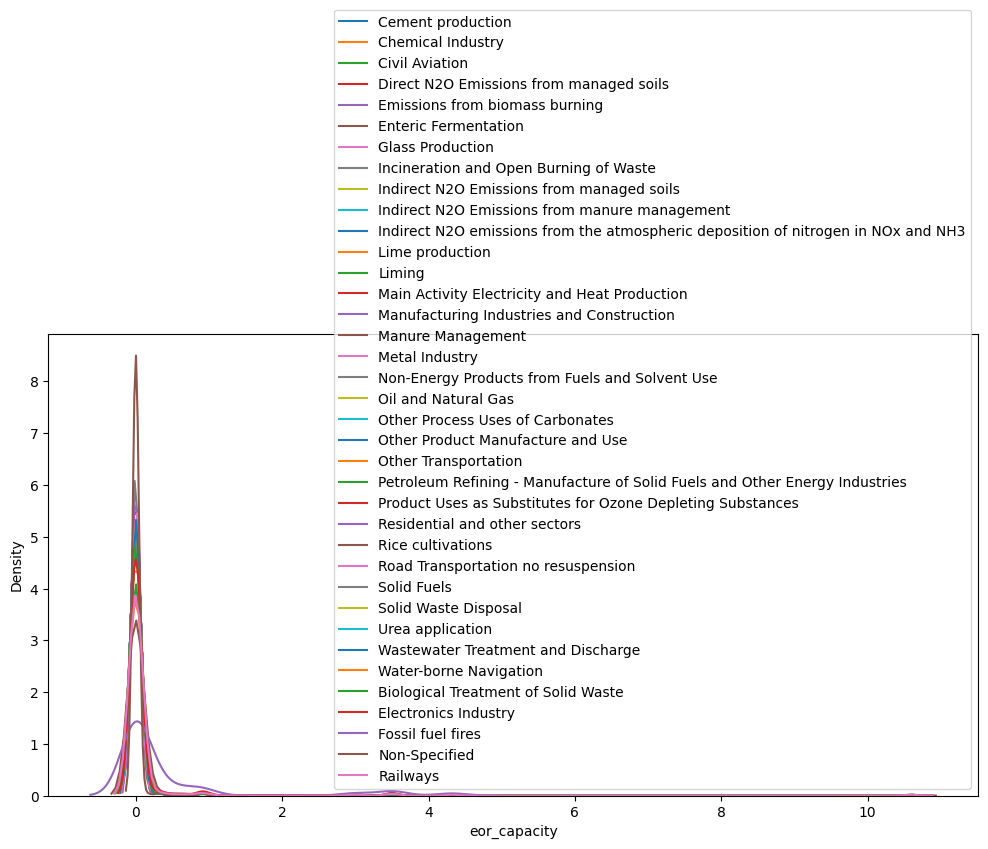

In [142]:
plt.figure(figsize=(12, 6))
for country in event_df['emissions_sector'].unique():
    subset = event_df[event_df['emissions_sector'] == country]
    sns.kdeplot(subset['eor_capacity'], label=country)
plt.legend()
plt.show()


Your plots show heterogeneous CCUS capacity trends (e.g., jumps in Natural Gas/LNG post-2015, flatlines in Cement). Borusyak’s method accounts for this without biased aggregation.

High within-sector variance in emissions is mitigated by imputation-based efficiency gains

In [131]:
results['att_df']

,event_time,att,se
0,-5,NaN,NaN
1,-4,NaN,NaN
2,-3,NaN,NaN
3,-2,NaN,NaN
4,-1,NaN,NaN
5,0,NaN,NaN
6,1,NaN,NaN
7,2,NaN,NaN
8,3,NaN,NaN
9,4,NaN,NaN


In [87]:
plot_event_study(results['att_df'], title="Dynamic ATT: EOR Capacity on Emissions")

NameError: name 'results' is not defined

In [86]:
def plot_event_study(att_df, title="Event Study: Dynamic ATT"):
    plt.figure(figsize=(10,6))
    plt.axhline(0, color='grey', linestyle='--')
    plt.errorbar(
        att_df['event_time'], att_df['att'],
        yerr=1.96*att_df['se'], fmt='o-', capsize=3, label='ATT (95% CI)'
    )
    plt.xlabel("Event Time (years from policy/treatment)")
    plt.ylabel("Estimated ATT on Emissions")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
# --- Plot dynamic ATT ---
plot_event_study(results['att_df'], title="Dynamic ATT: EOR Capacity on Emissions")


NameError: name 'results' is not defined

In [91]:
import matplotlib.pyplot as plt

def plot_event_study(df, event_time_col, att_col, se_col=None, title="Event Study: Dynamic ATT"):
    plt.figure(figsize=(10,6))
    plt.axhline(0, color='grey', linestyle='--')
    plt.plot(df[event_time_col], df[att_col], marker='o', label='ATT')
    if se_col is not None:
        plt.fill_between(
            df[event_time_col],
            df[att_col] - 1.96 * df[se_col],
            df[att_col] + 1.96 * df[se_col],
            alpha=0.2, label='95% CI'
        )
    plt.xlabel("Event Time (years from policy/treatment)")
    plt.ylabel("Estimated ATT on Emissions")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [246]:
model.__dict__

{'_results': <statsmodels.regression.linear_model.OLSResults at 0x1f084727dd0>,
 '__doc__': "\nResults class for for an OLS model.\n\nParameters\n----------\nmodel : RegressionModel\n    The regression model instance.\nparams : ndarray\n    The estimated parameters.\nnormalized_cov_params : ndarray\n    The normalized covariance parameters.\nscale : float\n    The estimated scale of the residuals.\ncov_type : str\n    The covariance estimator used in the results.\ncov_kwds : dict\n    Additional keywords used in the covariance specification.\nuse_t : bool\n    Flag indicating to use the Student's t in inference.\n**kwargs\n    Additional keyword arguments used to initialize the results.\n\nSee Also\n--------\nRegressionResults\n    Results store for WLS and GLW models.\n\nNotes\n-----\nMost of the methods and attributes are inherited from RegressionResults.\nThe special methods that are only available for OLS are:\n\n- get_influence\n- outlier_test\n- el_test\n- conf_int_el\n"}

In [1181]:
def plot_pre_trends(results):
    """Visualizes pre-treatment coefficients with confidence intervals"""
    coefs = results['pre_coefs']
    ci = results['regression_summary'].tables[1].data[1:]
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(x=range(-5, 0), y=coefs.values, 
                yerr=[ci[:, 4].astype(float), ci[:, 5].astype(float)],
                fmt='o', capsize=5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Pre-Treatment Coefficients with 95% CIs")
    plt.xlabel("Years Before Event")
    plt.ylabel("Treatment Effect")
    plt.show()

plot_pre_trends(df_merged_cleaned)

KeyError: 'pre_coefficients'

In [215]:
"""variation_by_feature = df_event.groupby(['Country', 'Sector', 'CCUS_sector', 'emissions_sector'])['eor_capacity'].agg(['mean', 'std', 'var', 'count'])
# Calculate CV (std/mean) for each potential clustering variable
for col in ['Country', 'Sector', 'CCUS_sector', 'emissions_sector']:
    df_event[f'{col}_cv'] = df_event.groupby(col)['eor_capacity'].transform('std') / df.groupby(col)['eor_capacity'].transform('mean')
"""
from statsmodels.formula.api import ols

r_squared_dict = {}
# For each potential clustering variable
for var in ['Sector', 'Country', 'CCUS_sector', 'emissions_sector']:
    formula = f"eor_capacity ~ C({var})"
    model = ols(formula, data=df_event).fit()
    r_squared = model.rsquared
    r_squared_dict[var] = r_squared
    
# Display the R-squared values
print(pd.Series(r_squared_dict).sort_values(ascending=False))


CCUS_sector         5.988998e-01
Country            -3.552714e-15
Sector             -4.440892e-15
emissions_sector   -4.662937e-15
dtype: float64


In [261]:
# For each feature, compute CV within groups
features = ['Country', 'Sector', 'CCUS_sector', 'emissions_sector']
import numpy as np
import statsmodels.formula.api as smf

def variance_decomposition(df, variable, group_var):
    var = variable
    overall_var = df[variable].var()
    group_means = df.groupby(group_var)[variable].mean()
    between_var = np.sum(df.groupby(group_var).size() * (group_means - df[variable].mean())**2) / len(df)
    within_var = overall_var - between_var
    formula = f"eor_capacity ~ C({var})"
    #model = smf.ols(formula, data=df_event).fit()
   # r_squared = model.rsquared
    print(f"Feature: {group_var}")
    print(f"    Total Variance: {overall_var:.4f}")
    print(f"    Between-Group Variance: {between_var:.4f}")
    print(f"    Within-Group Variance: {within_var:.4f}")
    print(f"    Proportion of variance explained by {group_var}: {between_var / overall_var:.2%}")
    #print(f"    R Squared: {r_squared}\n")

# Apply for each feature
for feature in features:
    variance_decomposition(df_merged_cleaned, 'd_log_total_capacity', feature)


Feature: Country
    Total Variance: 0.0123
    Between-Group Variance: 0.0000
    Within-Group Variance: 0.0123
    Proportion of variance explained by Country: 0.00%
Feature: Sector
    Total Variance: 0.0123
    Between-Group Variance: 0.0000
    Within-Group Variance: 0.0123
    Proportion of variance explained by Sector: 0.00%
Feature: CCUS_sector
    Total Variance: 0.0123
    Between-Group Variance: 0.0000
    Within-Group Variance: 0.0123
    Proportion of variance explained by CCUS_sector: 0.00%
Feature: emissions_sector
    Total Variance: 0.0123
    Between-Group Variance: 0.0000
    Within-Group Variance: 0.0123
    Proportion of variance explained by emissions_sector: 0.00%


Your analysis examines how changes in EOR capacity affect emissions over time using a generalized DiD approach:

The treatment is defined as changes in EOR capacity beyond a threshold

You're estimating effects at different time points relative to this threshold crossing

The wide confidence intervals in your clustered results suggest limited statistical power

The more uniform results with properly clustered standard errors (bottom plot) are likely more accurate, showing no statistically significant effect of EOR capacity changes on emissions when accounting for the correlation structure in your data.